In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle
from scipy.cluster.hierarchy import to_tree, ClusterNode, dendrogram
from typing import Dict, Tuple, List, Union, Optional
from ete3 import Tree
from ete3 import PhyloTree
import os

BASE_PATH = "/".join(os.getcwd().split("/")) # base dire"ctory level

DATA_PATH = os.path.join(BASE_PATH, "../../../downloads/")  # where I dump new data
COMP_PATH = os.path.join(DATA_PATH,"1KGvs1KG")

In [2]:
def get_window_dendrogram(w, idx, ymax = None, ymin = -.001):
    fig, ax = plt.subplots(1, figsize=(25,3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    sch.set_link_color_palette(['darkgrey', 'grey','black'])
    Z=tree_complete[w][0]
    dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)
    #plt.xticks([])
    plt.xlim(left = -10)
    plt.ylim(bottom = ymin)
    if ymax is not None:
        plt.ylim(top = ymax)

    # plt.tick_params(
    # axis='x',          # changes apply to the x-axis
    # which='both',      # both major and minor ticks are affected
    # bottom=False,      # ticks along the bottom edge are off
    # top=False,         # ticks along the top edge are off
    # labelbottom=False)


    leaf_x = [(x * 10)+5 for x in dg['leaves']]
    leaf_y = [0] * 132

    sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'hsmrca':'grey', 'gagp':'black'}

    lineage_dict = {}
    for i in range(len(idx)):
        lineage_dict[i]=idx[i]
        
    colors = {}
    for k in lineage_dict.keys():
        i = k*10 + 5
        c = lineage_dict[k]
        if (c != 'hsmrca') & (c!='gagp'):
            c = c[:3]
        c = sup_pal[c]
        colors[i] = c

    new_colors = [colors[i] for i in leaf_x]

    # create new x for plotting leaves
    new_leaf_x = range(5,1325,10)
    plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10)
    
    plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
    plt.ylabel('Divergence\n', size = 14) # label of the y-axis
    plt.title(str(w))
    plt.show()
    return Z


def one_window_tree(dict3d, w, tree_summary, tree_complete, link_method, idx):
        window_df = dict_3d[w].loc[idx][idx]
        length = len(idx)
        array = window_df.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
        condensed = array[np.triu_indices(length, k = 1)]
        Z = sch.linkage(condensed, method = link_method)
        dendrogram = sch.dendrogram(Z, labels=idx)
        whole_tree = [Z, dendrogram]

        cluster_sample_IDs = dendrogram['leaves']
        cluster_IDs = dendrogram['leaves_color_list']
        clusters_dict = dict(zip(cluster_sample_IDs, cluster_IDs))

        cluster_IDs_list = []
        for key, value in sorted(clusters_dict.items()):
                cluster_IDs_list.append(value)

        top_tree_y = dendrogram['dcoord'][-1]
        window_stats = cluster_IDs_list + top_tree_y


        return window_stats, whole_tree


def _scipy_tree_to_newick_list(node: ClusterNode, newick: List[str], parentdist: float, leaf_names: List[str]) -> List[str]:
    """Construct Newick tree from SciPy hierarchical clustering ClusterNode

    This is a recursive function to help build a Newick output string from a scipy.cluster.hierarchy.to_tree input with
    user specified leaf node names.

    Notes:
        This function is meant to be used with `to_newick`

    Args:
        node (scipy.cluster.hierarchy.ClusterNode): Root node is output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        parentdist (float): Distance of parent node of `node`
        newick (list of string): Newick string output accumulator list which needs to be reversed and concatenated (i.e. `''.join(newick)`) for final output
        leaf_names (list of string): Leaf node names

    Returns:
        (list of string): Returns `newick` list of Newick output strings
    """
    if node.is_leaf():
        return newick + [f'{leaf_names[node.id]}:{parentdist - node.dist}']

    if len(newick) > 0:
        newick.append(f'):{parentdist - node.dist}')
    else:
        newick.append(');')
    newick = _scipy_tree_to_newick_list(node.get_left(), newick, node.dist, leaf_names)
    newick.append(',')
    newick = _scipy_tree_to_newick_list(node.get_right(), newick, node.dist, leaf_names)
    newick.append('(')
    return newick


def to_newick(tree: ClusterNode, leaf_names: List[str]) -> str:
    """Newick tree output string from SciPy hierarchical clustering tree

    Convert a SciPy ClusterNode tree to a Newick format string.
    Use scipy.cluster.hierarchy.to_tree on a hierarchical clustering linkage matrix to create the root ClusterNode for the `tree` input of this function.

    Args:
        tree (scipy.cluster.hierarchy.ClusterNode): Output of scipy.cluster.hierarchy.to_tree from hierarchical clustering linkage matrix
        leaf_names (list of string): Leaf node names

    Returns:
        (string): Newick output string
    """
    newick_list = _scipy_tree_to_newick_list(tree, [], tree.dist, leaf_names)
    return ''.join(newick_list[::-1])


def name_internal_nodes(T):
    for node in T.traverse():
        if node.is_leaf()==False:
            # list names of leaves
            leaf_names=[leaf.name for leaf in node.iter_leaves()]
            names_unique = list(set(leaf_names))
            # if all leaves have the same name, give that name to the node
            if (len(names_unique)==1):
                node.name = names_unique[0]

def collapsed_leaf(node):
    if len(node2labels[node]) == 1:
       return True
    else:
       return False

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Clustering with Ancestral

### Set Up

In [4]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % DATA_PATH,
                       index_col=0)
windows = pd.read_table('%s/intermediates/windows_to_keep.csv' % DATA_PATH, sep=',', index_col=[1,2]).drop(columns=['Unnamed: 0'])

dict_seq = pickle.load( open( "%s/dict_seq.p" % DATA_PATH, "rb" ) )
matrix_seq = pickle.load( open( "%s/matrix_seq.p" % DATA_PATH, "rb" ) )

dict_3d = pickle.load( open( "%s/dict_3d.p" % DATA_PATH, "rb" ) )
matrix_3d = pickle.load( open( "%s/matrix_3d.p" % DATA_PATH, "rb" ) )


hsmrca_gagp = pd.read_table('%s/3dcomp_hsmrca_ancestral_vs_GAGP_ancestral.txt' % DATA_PATH, index_col=[0,1])
windows_tuples = list(dict_3d.keys())
hsmrca_gagp['div'] = 1-hsmrca_gagp['spearman']


sub_pops = list(set(comp_list.sub1).union(comp_list.sub2))
sub_pal = dict.fromkeys(sub_pops)
amr_pal = sns.diverging_palette(50,230, s=82, l=58, n=10)[-4:]
eur_pal = sns.diverging_palette(50,230, s=82, l=58, n=15)[:5]
afr_pal = sns.diverging_palette(50,369, s=82, l=58, n=17)[-7:]
sas_pal = sns.diverging_palette(190,369, s=82, l=58, n=12)[:5]
eas_pal = sns.diverging_palette(110,105, s=75, l=65, n=10)[:5]
sub_pal['GBR'] = eur_pal[0]
sub_pal['FIN'] = eur_pal[1]
sub_pal['IBS'] = eur_pal[2]
sub_pal['CEU'] = eur_pal[3]
sub_pal['TSI'] = eur_pal[4]

sub_pal['PEL'] = amr_pal[0]
sub_pal['CLM'] = amr_pal[1]
sub_pal['MXL'] = amr_pal[2]
sub_pal['PUR'] = amr_pal[3]

sub_pal['CHB'] = eas_pal[0]
sub_pal['JPT'] = eas_pal[1]
sub_pal['CHS'] = eas_pal[2]
sub_pal['CDX'] = eas_pal[3]
sub_pal['KHV'] = eas_pal[4]

sub_pal['ITU'] = sas_pal[0]
sub_pal['PJL'] = sas_pal[1]
sub_pal['BEB'] = sas_pal[2]
sub_pal['STU'] = sas_pal[3]
sub_pal['GIH'] = sas_pal[4]

sub_pal['ASW'] = afr_pal[0]
sub_pal['ACB'] = afr_pal[1]
sub_pal['GWD'] = afr_pal[2]
sub_pal['LWK'] = afr_pal[3]
sub_pal['ESN'] = afr_pal[4]
sub_pal['YRI'] = afr_pal[5]
sub_pal['MSL'] = afr_pal[6]

sub_pal['hsmrca'] = 'grey'
sub_pal['gagp'] = 'black'

In [5]:
idx_wa = sorted(set(comp_list.ind1).union(comp_list.ind2))
idx_hsmrca = idx_wa + ['hsmrca']
idx = idx_hsmrca + ['gagp']

anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % DATA_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
anc_div.columns = ['_'.join(col) for col in anc_div.columns.values]
anc_div = anc_div[idx_wa]

In [6]:
gagp_spear = pd.read_table('%s/comp_tables/gagp_window_spearman.csv' % DATA_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])

gagp_div = 1-gagp_spear
gagp_div.columns = ['_'.join(col) for col in gagp_div.columns.values]
gagp_div = gagp_div[idx_wa]
gagp_div['hsmrca'] = hsmrca_gagp['div']

In [7]:
for w in dict_3d.keys():
    b = anc_div.loc[[w]]
    b = b.reset_index(drop=True).rename(index={0:'hsmrca'})
    a = dict_3d[w].copy()
    a = a[idx_wa].loc[idx_wa].append(b)
    a['hsmrca'] = b.T['hsmrca']

    c = gagp_div.loc[[w]]
    c = c.reset_index(drop=True).rename(index={0:'gagp'})
    a = a[idx_hsmrca].loc[idx_hsmrca].append(c)
    a['gagp'] = c.T['gagp']

    dict_3d[w] = a

In [8]:
sub_idx = []
for i in idx:
    sub_idx.append(i[4:7])
sub_idx = sub_idx[:-2]
sub_idx.append('hsmrca')
sub_idx.append('gagp')

In [9]:
dict_3d[w]

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
AFR_ACB_female_HG01896                     NaN                0.006499   
AFR_ACB_female_HG02095                0.006499                     NaN   
AFR_ACB_female_HG02337                0.002956                0.008792   
AFR_ACB_female_HG02505                0.001120                0.005929   
AFR_ACB_female_HG02555                0.002114                0.006540   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.007758                0.002106   
SAS_STU_female_HG03944                0.002913                0.006188   
SAS_STU_female_HG03949                0.002147                0.008086   
hsmrca                                0.003188                0.004675   
gagp                                  0.118080                0.111680   

                        AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
AFR_ACB_female_HG01896                0.002956                0.001120   
AFR_ACB_female_HG02095                0.008792                0.005929   
AFR_ACB_female_HG02337                     NaN                0.003994   
AFR_ACB_female_HG02505                0.003994                     NaN   
AFR_ACB_female_HG02555                0.002056                0.001917   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.010068                0.007880   
SAS_STU_female_HG03944                0.003699                0.003067   
SAS_STU_female_HG03949                0.002353                0.002663   
hsmrca                                0.005659                0.003884   
gagp                                  0.124027                0.113013   

                        AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
AFR_ACB_female_HG01896                0.002114                0.003580   
AFR_ACB_female_HG02095                0.006540                0.008518   
AFR_ACB_female_HG02337                0.002056                0.004209   
AFR_ACB_female_HG02505                0.001917                0.003932   
AFR_ACB_female_HG02555                     NaN                0.003321   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.008687                0.010353   
SAS_STU_female_HG03944                0.003024                0.001576   
SAS_STU_female_HG03949                0.001903                0.001179   
hsmrca                                0.003720                0.005778   
gagp                                  0.116147                0.114520   

                        AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
AFR_ACB_female_HG01896                0.007582                0.006855   
AFR_ACB_female_HG02095                0.003737                0.001246   
AFR_ACB_female_HG02337                0.011469                0.008769   
AFR_ACB_female_HG02505                0.007275                0.006636   
AFR_ACB_female_HG02555                0.009445                0.007367   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.006544                0.001579   
SAS_STU_female_HG03944                0.009295                0.007179   
SAS_STU_female_HG03949                0.010108                0.008766   
hsmrca                                0.007842                0.003974   
gagp                                  0.115161                0.111557   

                        AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
AFR_ACB_female_HG01896                0.002891                0.002315  ...   
AFR_ACB_female_HG02095                0.006712                0.008715  ...   
AFR_ACB_female_HG02337                0.003719                0.004959  ...   
AFR_ACB_female_HG02505                0.003043                0.002816  ...   
AFR_ACB_female_HG02555                0.003487                0.004386  .

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


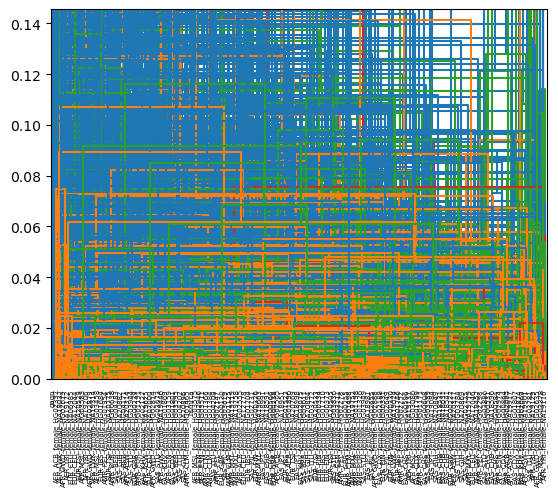

In [10]:
tree_summary = {}
tree_complete = {}
#takes about 3 minutes 20 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete', idx=idx)
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


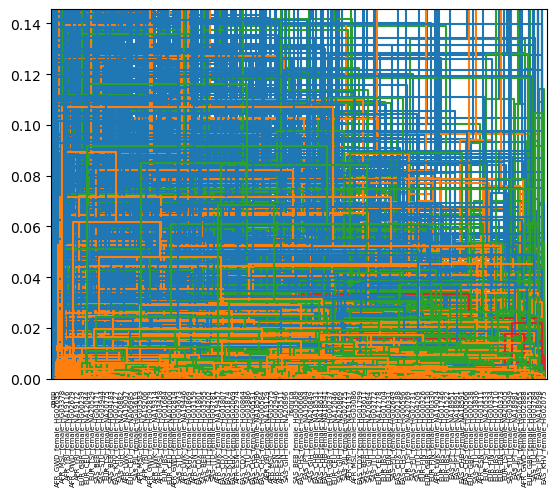

In [11]:
non_adm = []
for i in range(len(sub_idx)):
    p = sub_idx[i]
    if p not in ['ACB','ASW','CLM','MXL','PEL','PUR']:
        non_adm.append(i)

non_adm_ids = [idx[i] for i in non_adm]

# Non admixed version
tree_summary = {}
tree_complete = {}
#takes about 3 minutes 20 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete', idx=non_adm_ids)
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)

## Genome AVG w/ GAGP and HSMRCA

### 3D Divergence

In [12]:
b = pd.DataFrame(anc_div.mean(), columns=['hsmrca'])
a = matrix_3d.copy()
a = a[idx_wa].loc[idx_wa].append(b['hsmrca'])
a['hsmrca'] = b['hsmrca']

c = pd.DataFrame(gagp_div.mean(), columns=['gagp'])

a = a[idx_hsmrca].loc[idx_hsmrca].append(c['gagp'])
a['gagp'] = c['gagp']

In [13]:
a

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
AFR_ACB_female_HG01896                     NaN                0.003937   
AFR_ACB_female_HG02095                0.003937                     NaN   
AFR_ACB_female_HG02337                0.003889                0.004011   
AFR_ACB_female_HG02505                0.004065                0.003786   
AFR_ACB_female_HG02555                0.003898                0.003978   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.003942                0.003971   
SAS_STU_female_HG03944                0.004037                0.003896   
SAS_STU_female_HG03949                0.003960                0.003769   
hsmrca                                0.004175                0.004517   
gagp                                  0.017177                0.017463   

                        AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
AFR_ACB_female_HG01896                0.003889                0.004065   
AFR_ACB_female_HG02095                0.004011                0.003786   
AFR_ACB_female_HG02337                     NaN                0.004178   
AFR_ACB_female_HG02505                0.004178                     NaN   
AFR_ACB_female_HG02555                0.003981                0.003863   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.004227                0.003638   
SAS_STU_female_HG03944                0.004040                0.003824   
SAS_STU_female_HG03949                0.003977                0.003821   
hsmrca                                0.004594                0.004341   
gagp                                  0.017663                0.017278   

                        AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
AFR_ACB_female_HG01896                0.003898                0.004089   
AFR_ACB_female_HG02095                0.003978                0.004113   
AFR_ACB_female_HG02337                0.003981                0.004121   
AFR_ACB_female_HG02505                0.003863                0.003760   
AFR_ACB_female_HG02555                     NaN                0.004025   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.003634                0.003690   
SAS_STU_female_HG03944                0.003742                0.003651   
SAS_STU_female_HG03949                0.003940                0.003553   
hsmrca                                0.004432                0.004621   
gagp                                  0.017380                0.017782   

                        AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
AFR_ACB_female_HG01896                0.003789                0.004003   
AFR_ACB_female_HG02095                0.003536                0.004006   
AFR_ACB_female_HG02337                0.003876                0.004078   
AFR_ACB_female_HG02505                0.003756                0.004115   
AFR_ACB_female_HG02555                0.003878                0.004156   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.003660                0.004120   
SAS_STU_female_HG03944                0.003829                0.004157   
SAS_STU_female_HG03949                0.003728                0.004207   
hsmrca                                0.004246                0.004479   
gagp                                  0.017204                0.017418   

                        AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
AFR_ACB_female_HG01896                0.003812                0.003784  ...   
AFR_ACB_female_HG02095                0.003707                0.003530  ...   
AFR_ACB_female_HG02337                0.003756                0.003818  ...   
AFR_ACB_female_HG02505                0.003610                0.003911  ...   
AFR_ACB_female_HG02555                0.003743                0.004031  .

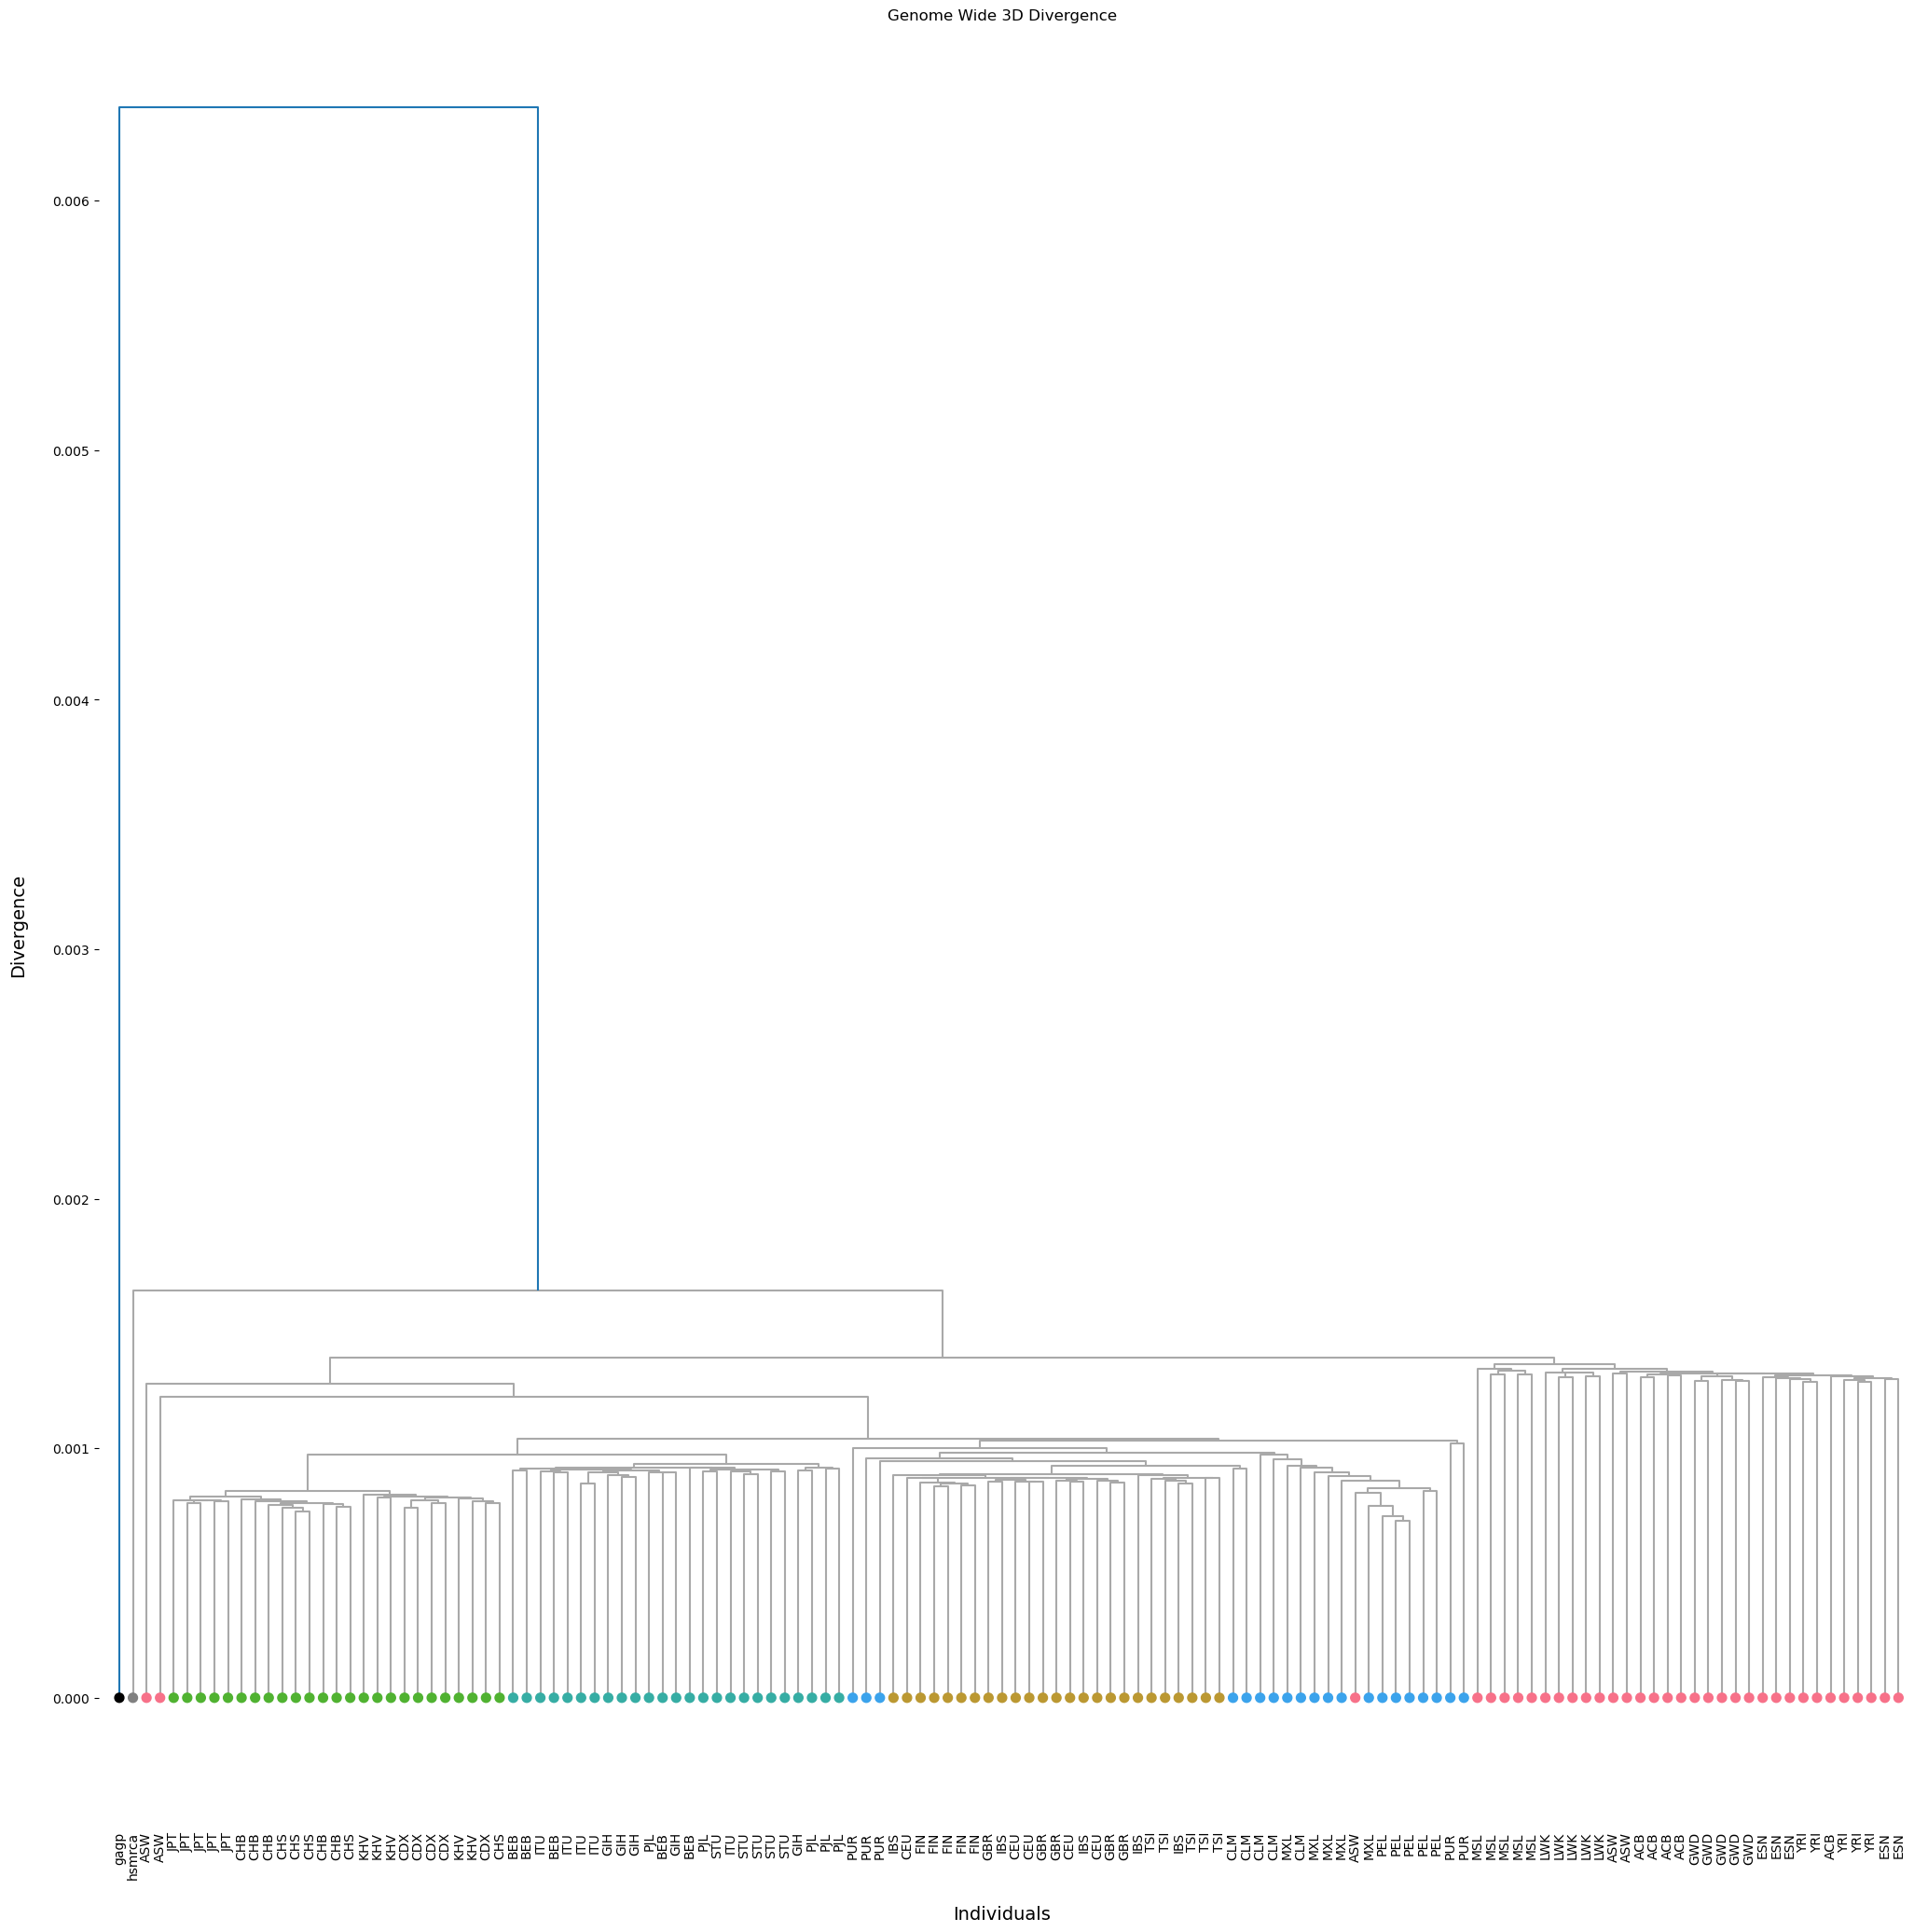

In [23]:
length = len(idx)
array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')

fig, ax = plt.subplots(1, figsize=(25,25))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sch.set_link_color_palette(['darkgrey', 'grey','black'])
dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)

plt.xlim(left = -10)
plt.ylim(bottom = -.0005)
# plt.tick_params(
# axis='x',          # changes apply to the x-axis
# which='both',      # both major and minor ticks are affected
# bottom=False,      # ticks along the bottom edge are off
# top=False,         # ticks along the top edge are off
# labelbottom=False)


leaf_x = [(x * 10)+5 for x in dg['leaves']]
leaf_y = [0] * 132

sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'hsmrca':'grey', 'gagp':'black'}

lineage_dict = {}
for i in range(len(idx)):
    lineage_dict[i]=idx[i]
    
colors = {}
for k in lineage_dict.keys():
    i = k*10 + 5
    c = lineage_dict[k]
    if (c != 'hsmrca') & (c!='gagp'):
        c = c[:3]
    c = sup_pal[c]
    colors[i] = c

new_colors = [colors[i] for i in leaf_x]

# create new x for plotting leaves
new_leaf_x = range(5,1325,10)
plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10, s = 50)
plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
plt.ylabel('Divergence\n', size = 14) # label of the y-axis
plt.title('Genome Wide 3D Divergence')
plt.show()

### Sequence Average

In [24]:
hsmrca_gagp_seq = pd.read_table('%s/SeqComps_hsmrca_ancestral_vs_GAGP_ancestral.txt' % DATA_PATH, index_col=[0,1], names=['chr','windowStartPos','hsmrcaCov','gagpCov','seqID'], skiprows=1)
hsmrca_gagp_seq = hsmrca_gagp_seq.loc[windows.index]
hsmrca_gagp_seq.seqID = hsmrca_gagp_seq.seqID.astype('float')
hsmrca_gagp_seq['seqDiff'] = 1-hsmrca_gagp_seq['seqID'] 

hsmrca_seq = pd.DataFrame(index = anc_div.index, columns = anc_div.columns)
gagp_seq = pd.DataFrame(index = anc_div.index, columns = anc_div.columns)
for i in anc_div.columns:
    print(i)
    # HSMRCA
    filename = "%s1KGvsHSMRCA/SeqComps_%s_vs_hsmrca_ancestral.txt" % (DATA_PATH, i)
    cols = ['chr','windowStartPos','modernCov','hsmrcaCov','seqID']

    icomp = pd.read_table(filename, index_col=[0,1], names=cols, skiprows=1)
    icomp = icomp.loc[windows.index]
    icomp.seqID = icomp.seqID.astype('float')
    icomp['seqDiff'] = 1-icomp['seqID']

    hsmrca_seq[i] = icomp['seqDiff']


    #GAGP
    filename = "%s1KGvsGAGP/SeqComps_%s_vs_GAGP_ancestral.txt" % (DATA_PATH, i)
    cols = ['chr','windowStartPos','modernCov','gagpCov','seqID']

    icomp = pd.read_table(filename, index_col=[0,1], names=cols, skiprows=1)
    icomp = icomp.loc[windows.index]
    icomp.seqID = icomp.seqID.astype('float')
    icomp['seqDiff'] = 1-icomp['seqID'] 

    gagp_seq[i] = icomp['seqDiff']


AFR_ACB_female_HG01896
AFR_ACB_female_HG02095
AFR_ACB_female_HG02337
AFR_ACB_female_HG02505
AFR_ACB_female_HG02555
AFR_ASW_female_NA19625
AFR_ASW_female_NA19901
AFR_ASW_female_NA19917
AFR_ASW_female_NA20314
AFR_ASW_female_NA20317
AFR_ESN_female_HG02946
AFR_ESN_female_HG02974
AFR_ESN_female_HG03111
AFR_ESN_female_HG03159
AFR_ESN_female_HG03511
AFR_GWD_female_HG02635
AFR_GWD_female_HG02679
AFR_GWD_female_HG02814
AFR_GWD_female_HG02879
AFR_GWD_female_HG02888
AFR_LWK_female_NA19024
AFR_LWK_female_NA19037
AFR_LWK_female_NA19314
AFR_LWK_female_NA19446
AFR_LWK_female_NA19457
AFR_MSL_female_HG03086
AFR_MSL_female_HG03378
AFR_MSL_female_HG03458
AFR_MSL_female_HG03575
AFR_MSL_female_HG03583
AFR_YRI_female_NA19116
AFR_YRI_female_NA19129
AFR_YRI_female_NA19137
AFR_YRI_female_NA19172
AFR_YRI_female_NA19206
AMR_CLM_female_HG01125
AMR_CLM_female_HG01366
AMR_CLM_female_HG01384
AMR_CLM_female_HG01465
AMR_CLM_female_HG01498
AMR_MXL_female_NA19663
AMR_MXL_female_NA19719
AMR_MXL_female_NA19752
AMR_MXL_fem

In [25]:
gagp_seq['hsmrca'] = hsmrca_gagp_seq['seqDiff']

In [26]:
gagp_seq

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
chr   windowStartPos                                                   
chr1  1048576                       0.007053                0.006964   
      1572864                       0.008629                0.008608   
      3145728                       0.008642                0.008781   
      3670016                       0.008368                0.008478   
      4194304                       0.008193                0.008269   
...                                      ...                     ...   
chr22 46661632                      0.008937                0.008935   
      47185920                      0.008929                0.008879   
      47710208                      0.009295                0.009254   
      48234496                      0.010205                0.010213   
      48758784                      0.010369                0.010429   

                      AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
chr   windowStartPos                                                   
chr1  1048576                       0.007178                0.007017   
      1572864                       0.008640                0.008593   
      3145728                       0.008676                0.008631   
      3670016                       0.008425                0.008378   
      4194304                       0.008251                0.008286   
...                                      ...                     ...   
chr22 46661632                      0.008901                0.008793   
      47185920                      0.008980                0.008880   
      47710208                      0.009315                0.009295   
      48234496                      0.010245                0.010159   
      48758784                      0.010476                0.010405   

                      AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
chr   windowStartPos                                                   
chr1  1048576                       0.006925                0.007000   
      1572864                       0.008597                0.008670   
      3145728                       0.008838                0.008762   
      3670016                       0.008541                0.008419   
      4194304                       0.008295                0.008204   
...                                      ...                     ...   
chr22 46661632                      0.008889                0.008862   
      47185920                      0.009017                0.008822   
      47710208                      0.009403                0.009174   
      48234496                      0.010256                0.010043   
      48758784                      0.010431                0.010168   

                      AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
chr   windowStartPos                                                   
chr1  1048576                       0.007051                0.007048   
      1572864                       0.008601                0.008559   
      3145728                       0.008660                0.008604   
      3670016                       0.008404                0.008415   
      4194304                       0.008237                0.008263   
...                                      ...                     ...   
chr22 46661632                      0.008778                0.008950   
      47185920                      0.008824                0.008949   
      47710208                      0.009321                0.009356   
      48234496                      0.010302                0.010218   
      48758784                      0.010472                0.010306   

                      AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
chr   windowStartPos                                                  ...   
chr1  1048576                       0.006997                0.006783  ...   
      1572864                       0.00850

In [27]:
gagp_seq

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
chr   windowStartPos                                                   
chr1  1048576                       0.007053                0.006964   
      1572864                       0.008629                0.008608   
      3145728                       0.008642                0.008781   
      3670016                       0.008368                0.008478   
      4194304                       0.008193                0.008269   
...                                      ...                     ...   
chr22 46661632                      0.008937                0.008935   
      47185920                      0.008929                0.008879   
      47710208                      0.009295                0.009254   
      48234496                      0.010205                0.010213   
      48758784                      0.010369                0.010429   

                      AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
chr   windowStartPos                                                   
chr1  1048576                       0.007178                0.007017   
      1572864                       0.008640                0.008593   
      3145728                       0.008676                0.008631   
      3670016                       0.008425                0.008378   
      4194304                       0.008251                0.008286   
...                                      ...                     ...   
chr22 46661632                      0.008901                0.008793   
      47185920                      0.008980                0.008880   
      47710208                      0.009315                0.009295   
      48234496                      0.010245                0.010159   
      48758784                      0.010476                0.010405   

                      AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
chr   windowStartPos                                                   
chr1  1048576                       0.006925                0.007000   
      1572864                       0.008597                0.008670   
      3145728                       0.008838                0.008762   
      3670016                       0.008541                0.008419   
      4194304                       0.008295                0.008204   
...                                      ...                     ...   
chr22 46661632                      0.008889                0.008862   
      47185920                      0.009017                0.008822   
      47710208                      0.009403                0.009174   
      48234496                      0.010256                0.010043   
      48758784                      0.010431                0.010168   

                      AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
chr   windowStartPos                                                   
chr1  1048576                       0.007051                0.007048   
      1572864                       0.008601                0.008559   
      3145728                       0.008660                0.008604   
      3670016                       0.008404                0.008415   
      4194304                       0.008237                0.008263   
...                                      ...                     ...   
chr22 46661632                      0.008778                0.008950   
      47185920                      0.008824                0.008949   
      47710208                      0.009321                0.009356   
      48234496                      0.010302                0.010218   
      48758784                      0.010472                0.010306   

                      AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
chr   windowStartPos                                                  ...   
chr1  1048576                       0.006997                0.006783  ...   
      1572864                       0.00850

In [37]:
for w in dict_seq.keys():
    b = hsmrca_seq.loc[[w]]
    b = b.reset_index(drop=True).rename(index={0:'hsmrca'})
    a = dict_seq[w].copy()
    a = a[idx_wa].loc[idx_wa].append(b)
    a['hsmrca'] = b.T['hsmrca']

    c = gagp_seq.loc[[w]]
    c = c.reset_index(drop=True).rename(index={0:'gagp'})
    a = a[idx_hsmrca].loc[idx_hsmrca].append(c)
    a['gagp'] = c.T['gagp']

    dict_seq[w] = a

In [38]:
b = pd.DataFrame(hsmrca_seq.mean(), columns=['hsmrca'])
a = matrix_seq.copy()
a = a[idx_wa].loc[idx_wa].append(b['hsmrca'])
a['hsmrca'] = b['hsmrca']

c = pd.DataFrame(gagp_seq.mean(), columns=['gagp'])

a = a[idx_hsmrca].loc[idx_hsmrca].append(c['gagp'])
a['gagp'] = c['gagp']

sup_idx = [i.split('_', 1)[0] for i in idx]

In [39]:
a

AFR_ACB_female_HG01896  AFR_ACB_female_HG02095  \
AFR_ACB_female_HG01896                     NaN                0.001297   
AFR_ACB_female_HG02095                0.001297                     NaN   
AFR_ACB_female_HG02337                0.001293                0.001292   
AFR_ACB_female_HG02505                0.001294                0.001296   
AFR_ACB_female_HG02555                0.001291                0.001295   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.001325                0.001317   
SAS_STU_female_HG03944                0.001318                0.001312   
SAS_STU_female_HG03949                0.001323                0.001311   
hsmrca                                0.001613                0.001622   
gagp                                  0.006359                0.006367   

                        AFR_ACB_female_HG02337  AFR_ACB_female_HG02505  \
AFR_ACB_female_HG01896                0.001293                0.001294   
AFR_ACB_female_HG02095                0.001292                0.001296   
AFR_ACB_female_HG02337                     NaN                0.001290   
AFR_ACB_female_HG02505                0.001290                     NaN   
AFR_ACB_female_HG02555                0.001297                0.001285   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.001301                0.001303   
SAS_STU_female_HG03944                0.001293                0.001294   
SAS_STU_female_HG03949                0.001290                0.001293   
hsmrca                                0.001614                0.001613   
gagp                                  0.006358                0.006357   

                        AFR_ACB_female_HG02555  AFR_ASW_female_NA19625  \
AFR_ACB_female_HG01896                0.001291                0.001299   
AFR_ACB_female_HG02095                0.001295                0.001295   
AFR_ACB_female_HG02337                0.001297                0.001295   
AFR_ACB_female_HG02505                0.001285                0.001293   
AFR_ACB_female_HG02555                     NaN                0.001291   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.001305                0.001204   
SAS_STU_female_HG03944                0.001293                0.001195   
SAS_STU_female_HG03949                0.001295                0.001195   
hsmrca                                0.001617                0.001602   
gagp                                  0.006361                0.006344   

                        AFR_ASW_female_NA19901  AFR_ASW_female_NA19917  \
AFR_ACB_female_HG01896                0.001293                0.001296   
AFR_ACB_female_HG02095                0.001306                0.001299   
AFR_ACB_female_HG02337                0.001295                0.001296   
AFR_ACB_female_HG02505                0.001300                0.001302   
AFR_ACB_female_HG02555                0.001294                0.001296   
...                                        ...                     ...   
SAS_STU_female_HG03886                0.001307                0.001304   
SAS_STU_female_HG03944                0.001295                0.001300   
SAS_STU_female_HG03949                0.001298                0.001299   
hsmrca                                0.001619                0.001614   
gagp                                  0.006363                0.006359   

                        AFR_ASW_female_NA20314  AFR_ASW_female_NA20317  ...  \
AFR_ACB_female_HG01896                0.001319                0.001294  ...   
AFR_ACB_female_HG02095                0.001305                0.001300  ...   
AFR_ACB_female_HG02337                0.001285                0.001283  ...   
AFR_ACB_female_HG02505                0.001288                0.001284  ...   
AFR_ACB_female_HG02555                0.001287                0.001298  .

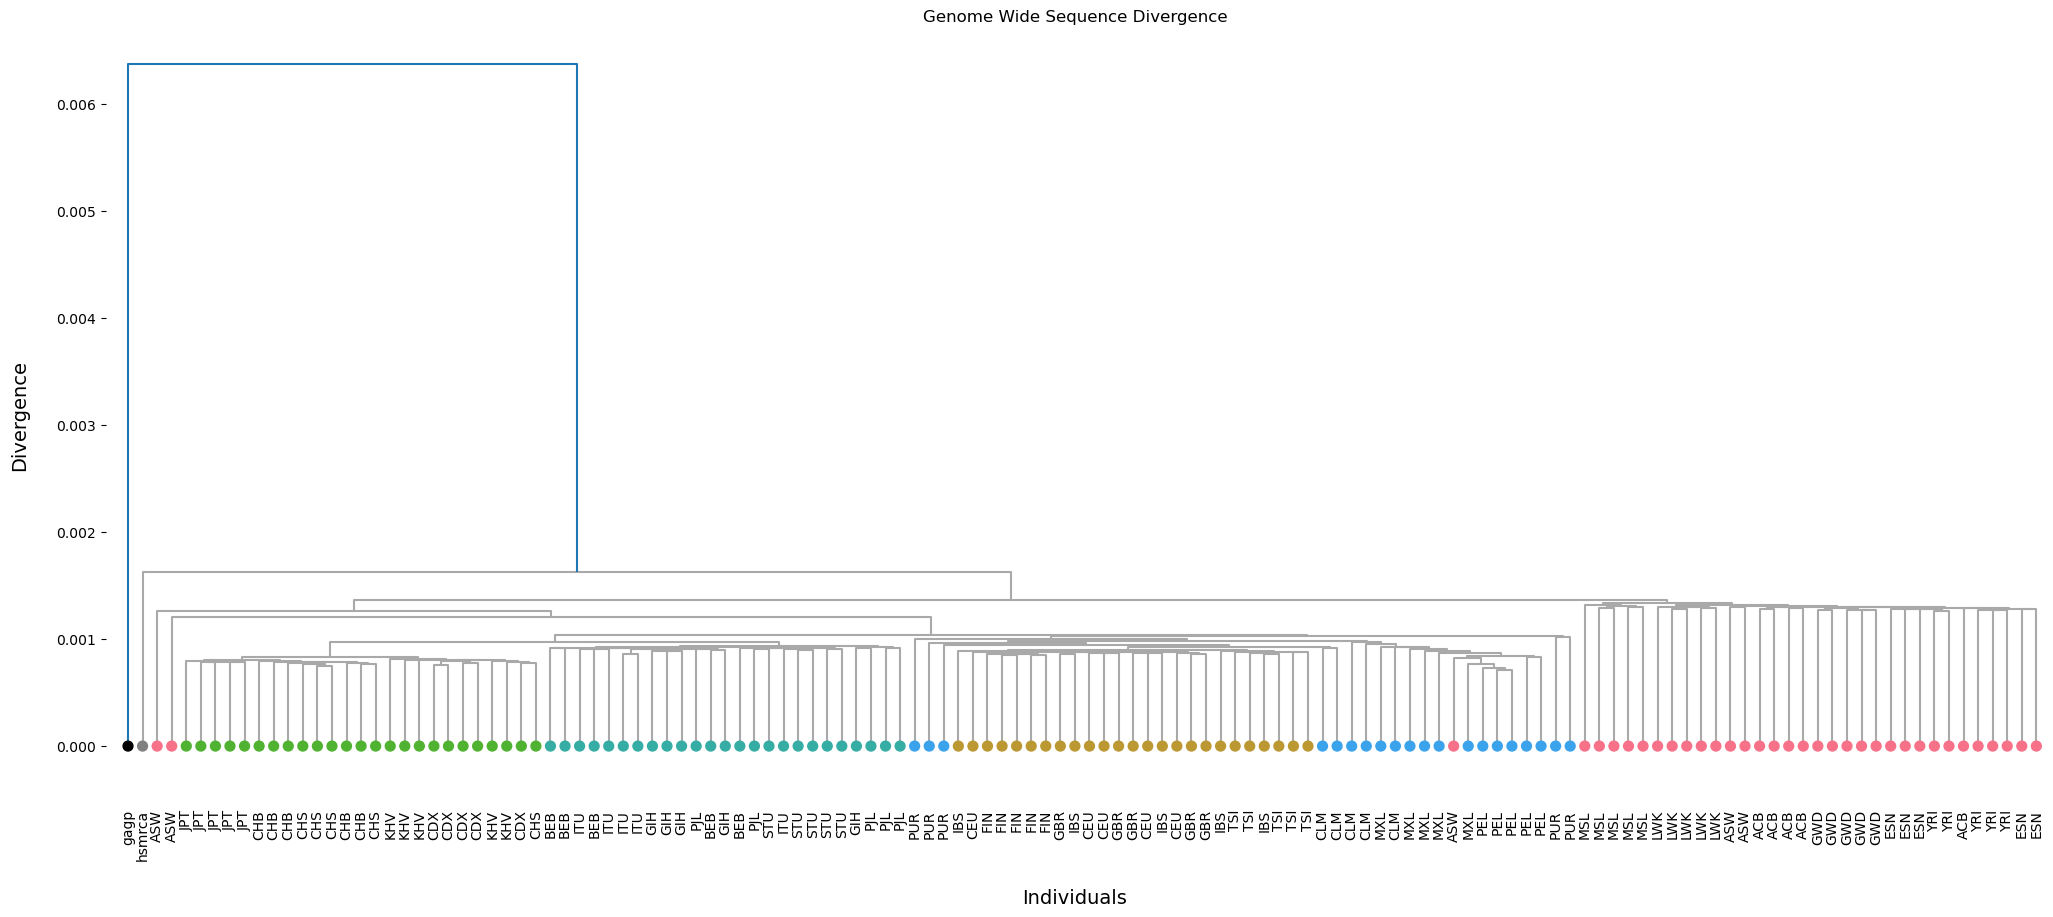

In [40]:
length = len(idx)
array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')

fig, ax = plt.subplots(1, figsize=(25,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sch.set_link_color_palette(['darkgrey', 'grey','black'])
dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx, leaf_font_size=10)

plt.xlim(left = -10)
plt.ylim(bottom = -.0005)
# plt.tick_params(
# axis='x',          # changes apply to the x-axis
# which='both',      # both major and minor ticks are affected
# bottom=False,      # ticks along the bottom edge are off
# top=False,         # ticks along the top edge are off
# labelbottom=False)


leaf_x = [(x * 10)+5 for x in dg['leaves']]
leaf_y = [0] * 132

sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'hsmrca':'grey', 'gagp':'black'}

lineage_dict = {}
for i in range(len(idx)):
    lineage_dict[i]=idx[i]
    
colors = {}
for k in lineage_dict.keys():
    i = k*10 + 5
    c = lineage_dict[k]
    if (c != 'hsmrca') & (c!='gagp'):
        c = c[:3]
    c = sup_pal[c]
    colors[i] = c

new_colors = [colors[i] for i in leaf_x]

# create new x for plotting leaves
new_leaf_x = range(5,1325,10)
plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10, s = 50)
plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
plt.ylabel('Divergence\n', size = 14) # label of the y-axis
plt.title('Genome Wide Sequence Divergence')
plt.show()

### Building baseline trees

In [32]:
non_adm = []
for i in range(len(sub_idx)):
    p = sub_idx[i]
    if p not in ['ACB','ASW','CLM','MXL','PEL','PUR']:
        non_adm.append(i)

non_adm_ids = [idx[i] for i in non_adm]
sub_idx_non_adm = [sub_idx[i] for i in non_adm]
a = a.loc[non_adm_ids][non_adm_ids]
sup_idx_non_adm = [i.split('_', 1)[0] for i in non_adm_ids]

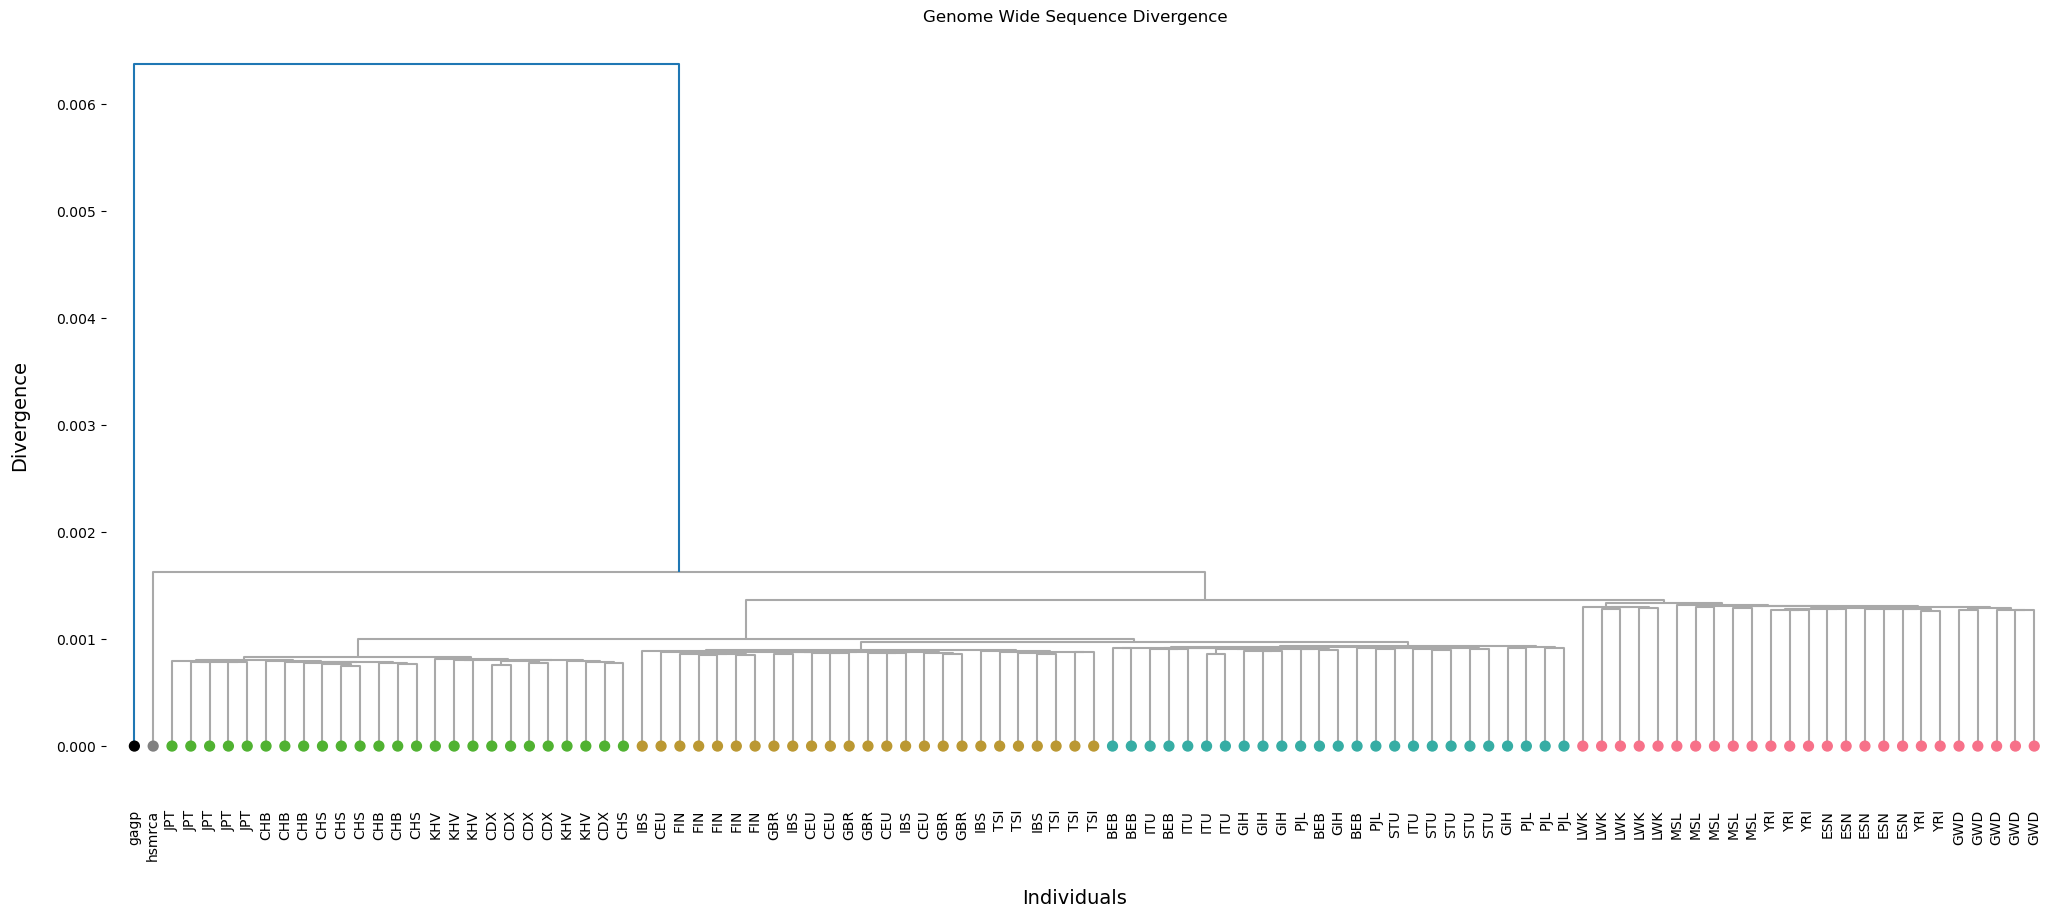

In [35]:
length = len(non_adm_ids)
array = a.reindex(index=non_adm_ids, columns=non_adm_ids).fillna(0, downcast='infer').to_numpy()
condensed = array[np.triu_indices(length, k = 1)]
Z = sch.linkage(condensed, method = 'complete')

fig, ax = plt.subplots(1, figsize=(25,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sch.set_link_color_palette(['darkgrey', 'grey','black'])
dg = sch.dendrogram(Z, show_leaf_counts=True, labels=sub_idx_non_adm, leaf_font_size=10)

plt.xlim(left = -10)
plt.ylim(bottom = -.0005)
# plt.tick_params(
# axis='x',          # changes apply to the x-axis
# which='both',      # both major and minor ticks are affected
# bottom=False,      # ticks along the bottom edge are off
# top=False,         # ticks along the top edge are off
# labelbottom=False)


leaf_x = [(x * 10)+5 for x in dg['leaves']]
leaf_y = [0] * 102

sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'hsmrca':'grey', 'gagp':'black'}

lineage_dict = {}
for i in range(len(non_adm_ids)):
    lineage_dict[i]=non_adm_ids[i]
    
colors = {}
for k in lineage_dict.keys():
    i = k*10 + 5
    c = lineage_dict[k]
    if (c != 'hsmrca') & (c!='gagp'):
        c = c[:3]
    c = sup_pal[c]
    colors[i] = c

new_colors = [colors[i] for i in leaf_x]

# create new x for plotting leaves
new_leaf_x = range(5,1025,10)
plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10, s = 50)
plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
plt.ylabel('Divergence\n', size = 14) # label of the y-axis
plt.title('Genome Wide Sequence Divergence')
plt.show()

In [34]:
t1 = Tree(to_newick(hc.to_tree(Z), sup_idx_non_adm), format=1)
name_internal_nodes(t1)
node2labels = t1.get_cached_content(store_attr="name")
seq_base = PhyloTree( t1.write(is_leaf_fn=collapsed_leaf, quoted_node_names=True), quoted_node_names=True)
print(seq_base)


         /-AFR
        |
      /-|      /-SAS
     |  |   /-|
     |   \-|   \-EUR
   /-|     |
  |  |      \-EAS
--|  |
  |   \-hsmrca
  |
   \-gagp


In [26]:
fake_base =  PhyloTree("(((AFR, (EUR, (EAS, SAS))),hsmrca), gagp);")

print(fake_base)


         /-AFR
      /-|
     |  |   /-EUR
     |   \-|
   /-|     |   /-EAS
  |  |      \-|
  |  |         \-SAS
--|  |
  |   \-hsmrca
  |
   \-gagp


### Windows

In [ ]:
dataframe = pd.DataFrame.from_dict(tree_summary, orient='index', columns=list(idx) + ['coord_0','coord_1','coord_2','coord_3'])

counts_df = dataframe.drop(columns=['coord_0','coord_1', 'coord_2','coord_3']).apply(lambda s: s.value_counts(), axis=1).fillna(0)     
counts_df['depth'] = dataframe['coord_1']

#### IDWs

In [18]:
dataframe

AFR_ACB_female_HG01896 AFR_ACB_female_HG02095  \
(chr1, 1048576)                       C1                     C1   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C1                     C2   
(chr1, 4194304)                       C1                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C1                     C3   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C1                     C1   

                  AFR_ACB_female_HG02337 AFR_ACB_female_HG02505  \
(chr1, 1048576)                       C1                     C1   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C1                     C2   
(chr1, 4194304)                       C1                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C1                     C1   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C1                     C1   

                  AFR_ACB_female_HG02555 AFR_ASW_female_NA19625  \
(chr1, 1048576)                       C1                     C1   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C2   
(chr1, 3670016)                       C2                     C2   
(chr1, 4194304)                       C2                     C2   
...                                  ...                    ...   
(chr22, 46661632)                     C1                     C1   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C1                     C1   

                  AFR_ASW_female_NA19901 AFR_ASW_female_NA19917  \
(chr1, 1048576)                       C1                     C1   
(chr1, 1572864)                       C1                     C1   
(chr1, 3145728)                       C3                     C3   
(chr1, 3670016)                       C0                     C1   
(chr1, 4194304)                       C2                     C1   
...                                  ...                    ...   
(chr22, 46661632)                     C1                     C1   
(chr22, 47185920)                     C1                     C1   
(chr22, 47710208)                     C2                     C2   
(chr22, 48234496)                     C2                     C2   
(chr22, 48758784)                     C1                     C1   

                  AFR_ASW_female_NA20314 AFR_ASW_female_NA20317  ...  \
(chr1, 1048576)                       C1                     C1  ...   
(chr1, 1572864)                       C1                     C1  ...   
(chr1, 3145728)                       C3                     C3  ...   
(chr1, 3670016)                       C1                     C2  ...   
(chr1, 4194304)                       C1                     C2  ...   
...                                  ...                    ...  ...   
(chr22, 46661632)                     C1                     C3  ...   
(chr22, 47185920)                     C1                     C1  ...   
(chr22, 47710208)                     C2                     C2  ...   
(chr22, 48234496)                     C2                     C2  ...   
(chr22

In [19]:
idw = counts_df[(counts_df.C0==1 )|(counts_df.C1==1)|(counts_df.C2==1)|(counts_df.C3==1)|(counts_df.C4==1)]
idw_list = []
for r in idw.index:
    row = dataframe.loc[[r]]
    ind = row.where(row=='C0').dropna(how='all').dropna(axis=1).dropna(axis=1).columns[0]
    idw_list.append(ind)

In [20]:
len(idw_list)

2724

In [21]:
idw['individual'] = idw_list

In [22]:
idw.individual.value_counts().tail(n=50)

EAS_CHS_female_HG00608    4
EAS_CHB_female_NA18596    4
EUR_GBR_female_HG00255    4
EUR_IBS_female_HG01704    4
SAS_BEB_female_HG04171    4
EUR_FIN_female_HG00326    4
AMR_CLM_female_HG01384    4
EAS_KHV_female_HG02075    4
SAS_STU_female_HG03949    4
EUR_TSI_female_NA20769    4
SAS_BEB_female_HG04183    4
EUR_TSI_female_NA20529    4
EUR_FIN_female_HG00330    4
AMR_MXL_female_NA19758    4
SAS_GIH_female_NA20849    3
EUR_TSI_female_NA20505    3
EAS_CHB_female_NA18531    3
EUR_IBS_female_HG01746    3
SAS_PJL_female_HG02649    3
EUR_GBR_female_HG00239    3
AFR_ACB_female_HG02095    3
AMR_PEL_female_HG02252    3
SAS_GIH_female_NA20896    3
EAS_CHB_female_NA18541    3
SAS_BEB_female_HG03589    3
EAS_CHB_female_NA18591    3
EAS_CDX_female_HG00864    3
AMR_CLM_female_HG01366    2
AMR_MXL_female_NA19752    2
AMR_PEL_female_HG02278    2
AFR_YRI_female_NA19206    2
AMR_MXL_female_NA19779    2
EUR_FIN_female_HG00334    2
AMR_PUR_female_HG00638    2
AMR_MXL_female_NA19663    2
EUR_TSI_female_NA205

Text(0, 0.5, 'window count')

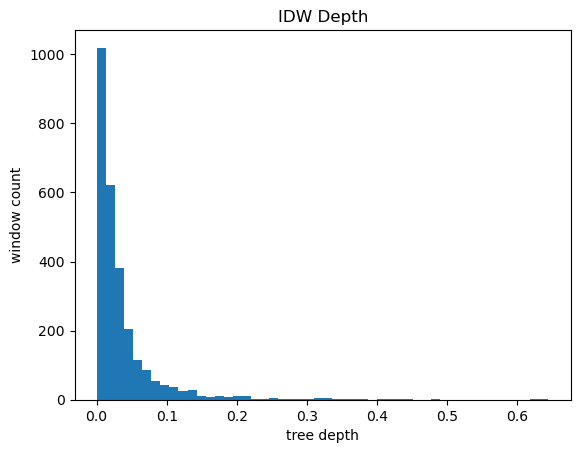

In [23]:
plt.hist(idw.depth, bins=50)
plt.title("IDW Depth")
plt.xlabel("tree depth")
plt.ylabel("window count")

In [24]:
def get_super_pop(idw_row):
    return idw_row.individual.split('_')[0]

In [25]:
idw_counts = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS','hsmrca','gagp'])
for key in idw_counts.keys():
    idw_counts[key] = 0

for i in range(idw.shape[0]):
    super_pop = get_super_pop(idw.iloc[i])
    idw_counts[super_pop] += 1

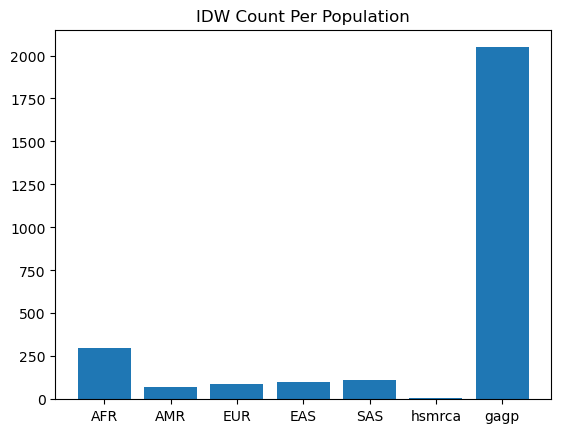

In [26]:
plt.bar(*zip(*idw_counts.items()))
plt.title('IDW Count Per Population')
plt.show()

In [27]:
sum(idw_counts.values())

2724

In [28]:
idw_counts.items()

dict_items([('AFR', 298), ('AMR', 72), ('EUR', 87), ('EAS', 103), ('SAS', 111), ('hsmrca', 5), ('gagp', 2048)])

In [29]:
298+72+87+103+111+5+2048

2724

#### FDWs

In [30]:
fdw = counts_df[((counts_df.C0<=5 )& (counts_df.C0>=2 ))|
                ((counts_df.C0 == 0.0) & ((counts_df.C1<=5 )& (counts_df.C1>=2 )))
                 # |
                # ((counts_df.C2<=5 )& (counts_df.C2>=2 ))|
                # ((counts_df.C3<=5 )& (counts_df.C3>=2 ))|
                # ((counts_df.C4<=5 )& (counts_df.C4>=2 ))|
                # ((counts_df.C5<=5 )& (counts_df.C5>=2 ))

]

In [31]:
def get_smallest_cluster(r, fdw):
    df = fdw.drop(columns=['depth'])
    fdw_row = df.loc[[r]]
    # idx = fdw_row.where(fdw_row != 0.0).dropna(axis=1).idxmin(axis=1).values[0]
    # size = fdw_row.where(fdw_row != 0.0).dropna(axis=1).min(axis=1).values[0]
    
    if fdw_row.C0.values[0] != 0.0:
        idx = 'C0'
    else:
        idx = 'C1'
    size = fdw_row[idx]
    return idx, size

def get_cluster_inds(cluster_id, window):
    inds = dataframe.loc[[window]].where(dataframe.loc[[window]]==cluster_id).dropna(axis=1).columns
    return list(inds)


def get_cluster_purity(df):
    pure_super_list=[]
    supers = []
    pure_sub_list=[]
    subs = []
    cluster_sizes = []
    num_clusters = []
    cs = counts_df[['C0','C1','C2','C3','C4']]
    for row in df.index:
        w = row
        c_n = cs.loc[[w]].where(cs.loc[[w]]!=0.0).dropna(axis=1).shape[1]
        c = get_smallest_cluster(w, df)
        c_id = c[0]
        c_size = int(c[1])
        inds = get_cluster_inds(c_id,w)
        super_pop = inds[0][:3]
        sub_pop = inds[0][4:7]
        pure_super = all(item.startswith(super_pop) for item in inds)
        pure_sub = all(item[4:7]==sub_pop for item in inds)
        pure_super_list.append(pure_super)
        pure_sub_list.append(pure_sub)

        cluster_sizes.append(c_size)
        num_clusters.append(c_n)
        if pure_super:
            supers.append(super_pop)
        else:
            supers.append(np.nan)
        if pure_sub:
            subs.append(sub_pop)
        else:
            subs.append(np.nan)
    df['pure_super'] = pure_super_list
    df['pure_sub'] = pure_sub_list

    df['super'] = supers
    df['sub'] = subs

    df['cluster_size'] = cluster_sizes
    df['num_clusters'] = num_clusters
    return df

    

In [32]:
fdw = get_cluster_purity(fdw)

In [33]:
fdw

C0     C1     C2     C3   C4     depth  pure_super  \
(chr1, 7340032)    2.0  130.0    0.0    0.0  0.0  0.003397       False   
(chr1, 9437184)    0.0    4.0  128.0    0.0  0.0  0.143960        True   
(chr1, 9961472)    0.0    4.0  128.0    0.0  0.0  0.031789        True   
(chr1, 15204352)   0.0    4.0  128.0    0.0  0.0  0.035709       False   
(chr1, 15728640)   0.0    4.0  128.0    0.0  0.0  0.021883       False   
...                ...    ...    ...    ...  ...       ...         ...   
(chr22, 26214400)  0.0    4.0   20.0  108.0  0.0  0.003762       False   
(chr22, 26738688)  0.0    2.0  130.0    0.0  0.0  0.030918        True   
(chr22, 27262976)  0.0    2.0  130.0    0.0  0.0  0.005388        True   
(chr22, 30932992)  0.0    3.0  129.0    0.0  0.0  0.019767        True   
(chr22, 31457280)  0.0    2.0  130.0    0.0  0.0  0.015619        True   

                   pure_sub super  sub  cluster_size  num_clusters  
(chr1, 7340032)       False   NaN  NaN             2             2  
(chr1, 9437184)       False   EUR  NaN             4             2  
(chr1, 9961472)       False   EUR  NaN             4             2  
(chr1, 15204352)      False   NaN  NaN             4             2  
(chr1, 15728640)      False   NaN  NaN             4             2  
...                     ...   ...  ...           ...           ...  
(chr22, 26214400)     False   NaN  NaN             4             3  
(chr22, 26738688)     False   EAS  NaN             2             2  
(chr22, 27262976)     False   EAS  NaN             2             2  
(chr22, 30932992)     False   SAS  NaN             3             2  
(chr22, 31457280)     False   SAS  NaN             2             2  

[777 rows x 12 columns]

Text(0.5, 1.0, 'Pure Subpop "Few" Driven Windows by Super Pop')

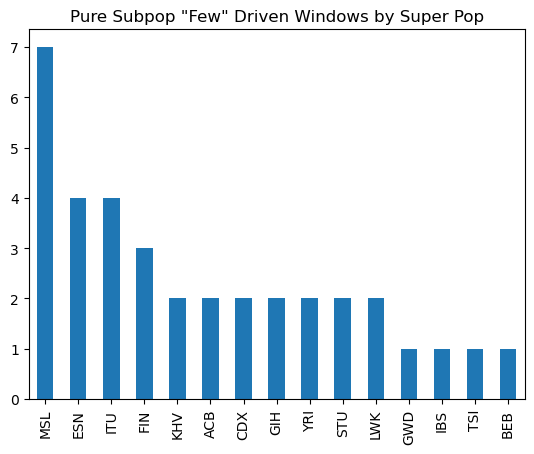

In [35]:
fdw[fdw.pure_sub==True]['sub'].value_counts().plot.bar()
plt.title('Pure Subpop "Few" Driven Windows by Super Pop')

In [36]:
fdw[fdw.pure_super==True].super.value_counts()

AFR    238
SAS     30
EAS     25
EUR     23
AMR      8
Name: super, dtype: int64

Text(0.5, 1.0, 'Pure Super pop "Few" Driven Windows by Super Pop')

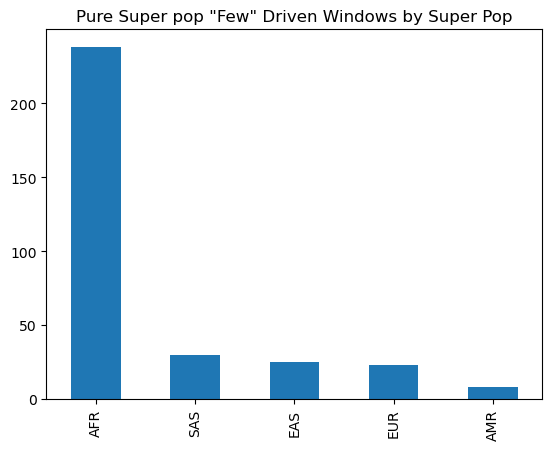

In [37]:
fdw[fdw.pure_super==True].super.value_counts().plot.bar()
plt.title('Pure Super pop "Few" Driven Windows by Super Pop')

In [38]:
fdw

C0     C1     C2     C3   C4     depth  pure_super  \
(chr1, 7340032)    2.0  130.0    0.0    0.0  0.0  0.003397       False   
(chr1, 9437184)    0.0    4.0  128.0    0.0  0.0  0.143960        True   
(chr1, 9961472)    0.0    4.0  128.0    0.0  0.0  0.031789        True   
(chr1, 15204352)   0.0    4.0  128.0    0.0  0.0  0.035709       False   
(chr1, 15728640)   0.0    4.0  128.0    0.0  0.0  0.021883       False   
...                ...    ...    ...    ...  ...       ...         ...   
(chr22, 26214400)  0.0    4.0   20.0  108.0  0.0  0.003762       False   
(chr22, 26738688)  0.0    2.0  130.0    0.0  0.0  0.030918        True   
(chr22, 27262976)  0.0    2.0  130.0    0.0  0.0  0.005388        True   
(chr22, 30932992)  0.0    3.0  129.0    0.0  0.0  0.019767        True   
(chr22, 31457280)  0.0    2.0  130.0    0.0  0.0  0.015619        True   

                   pure_sub super  sub  cluster_size  num_clusters  
(chr1, 7340032)       False   NaN  NaN             2             2  
(chr1, 9437184)       False   EUR  NaN             4             2  
(chr1, 9961472)       False   EUR  NaN             4             2  
(chr1, 15204352)      False   NaN  NaN             4             2  
(chr1, 15728640)      False   NaN  NaN             4             2  
...                     ...   ...  ...           ...           ...  
(chr22, 26214400)     False   NaN  NaN             4             3  
(chr22, 26738688)     False   EAS  NaN             2             2  
(chr22, 27262976)     False   EAS  NaN             2             2  
(chr22, 30932992)     False   SAS  NaN             3             2  
(chr22, 31457280)     False   SAS  NaN             2             2  

[777 rows x 12 columns]

In [39]:
fdw[fdw.pure_super==True].super.value_counts()

AFR    238
SAS     30
EAS     25
EUR     23
AMR      8
Name: super, dtype: int64

In [40]:
238+30+25+23+8

324

#### Homogeneous windows

In [41]:
test = get_cluster_purity(counts_df)

Text(0.5, 1.0, 'Size of first cluster')

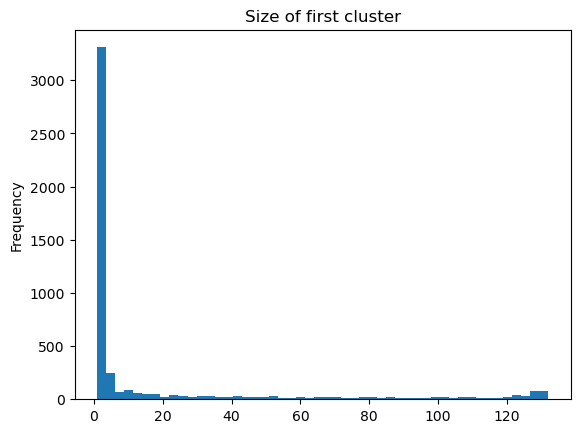

In [42]:
test.cluster_size.plot.hist(bins=50)
plt.title('Size of first cluster')

In [43]:
super_pure = test[test.pure_super]
sub_pure = test[test.pure_sub]

Text(0.5, 1.0, 'Homogeneous Cluster Size Distribution (super)')

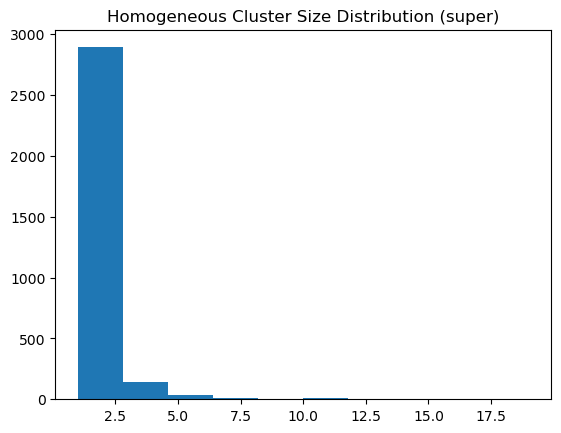

In [44]:
plt.hist(super_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (super)")

Text(0.5, 1.0, 'Homogeneous Cluster Size Distribution (sub)')

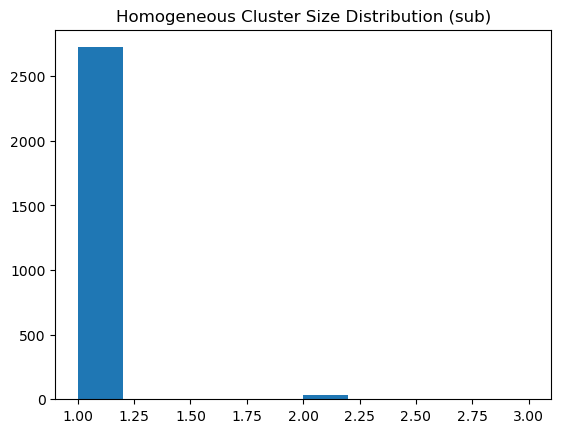

In [45]:
plt.hist(sub_pure.cluster_size)
plt.title("Homogeneous Cluster Size Distribution (sub)")

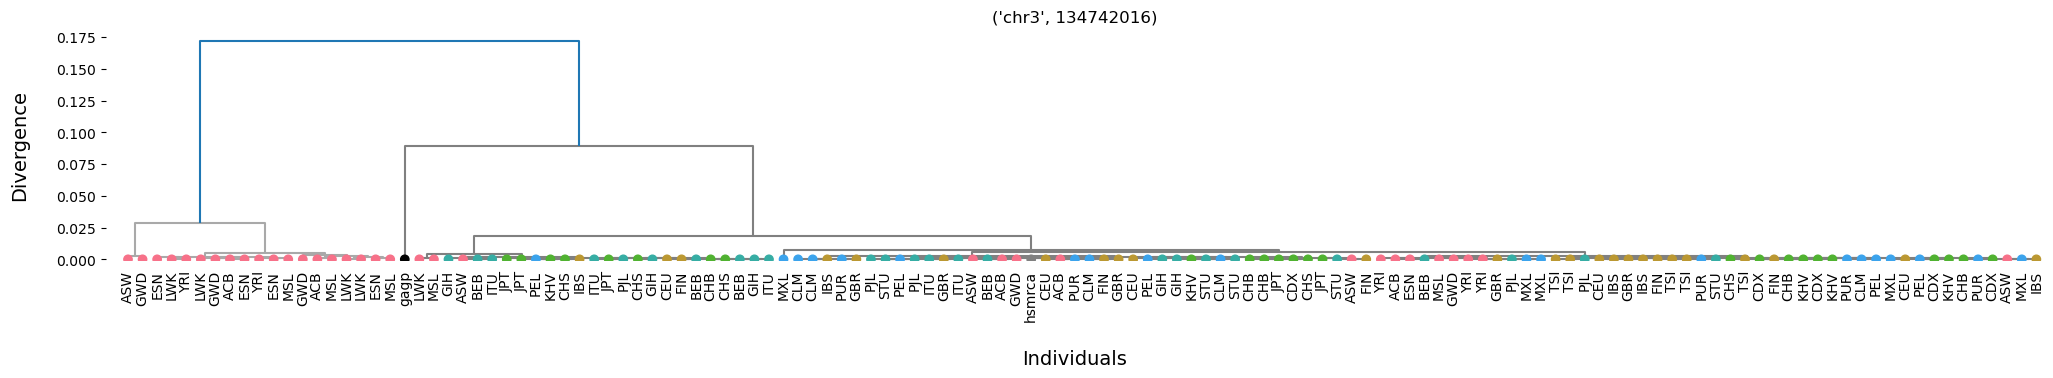

In [46]:
dendrogram = get_window_dendrogram(super_pure.cluster_size.idxmax(), idx)

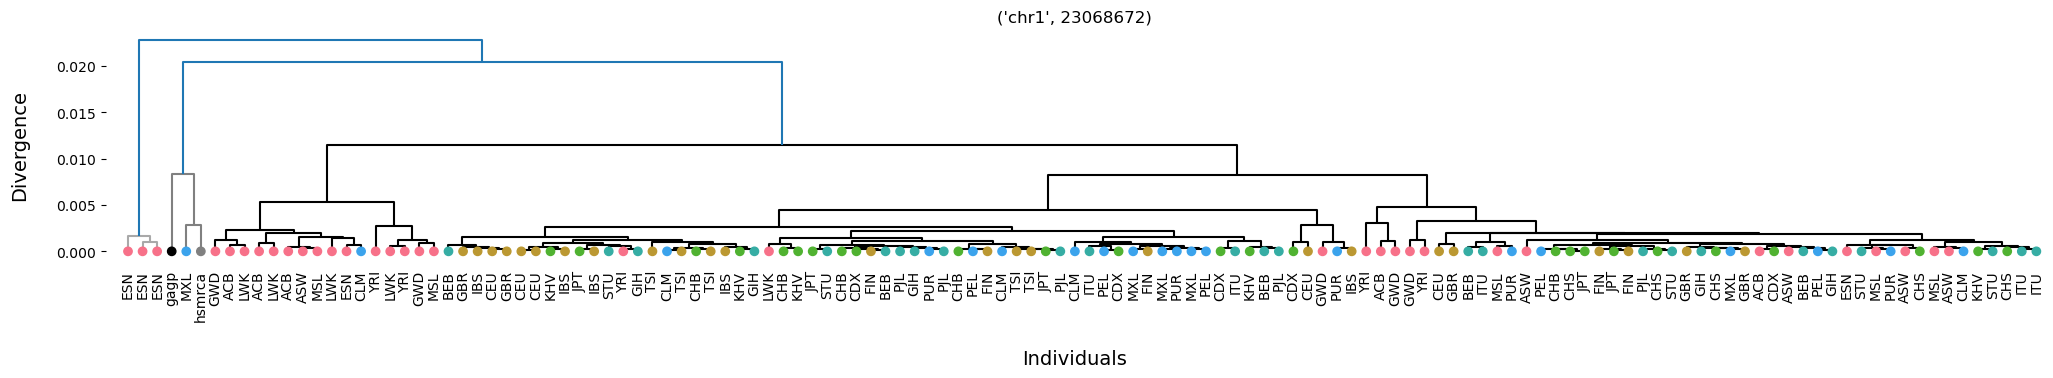

In [47]:
dendrogram = get_window_dendrogram(sub_pure.cluster_size.idxmax(), idx)

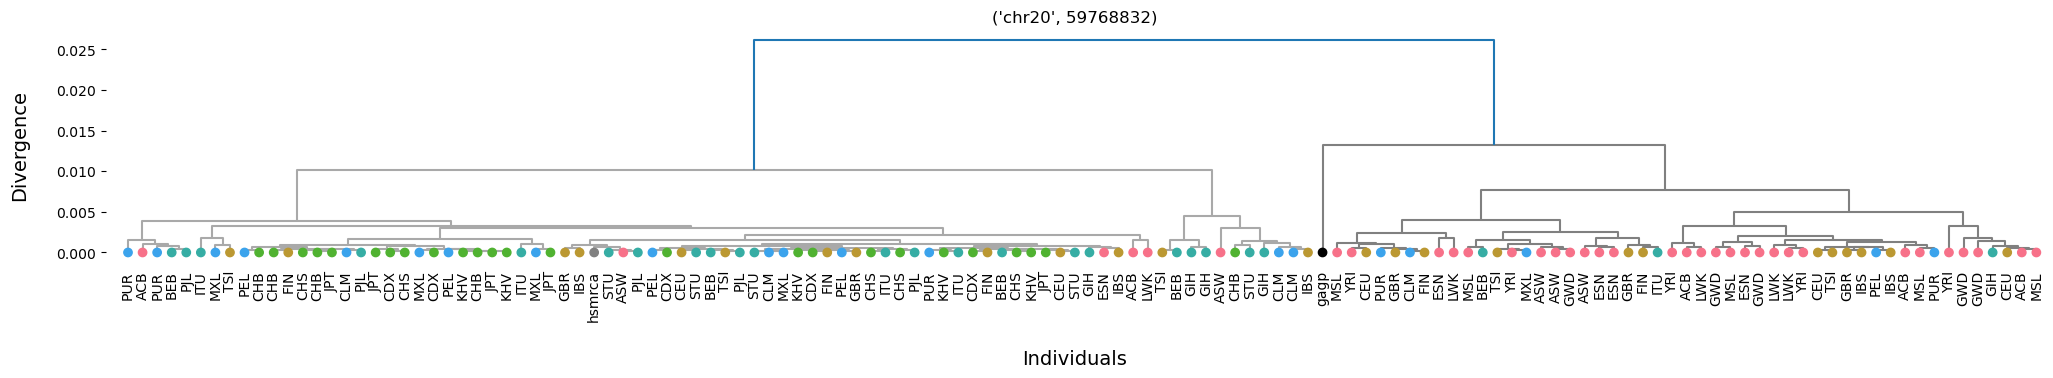

In [48]:
dendrogram = get_window_dendrogram(("chr20", 59768832), idx)

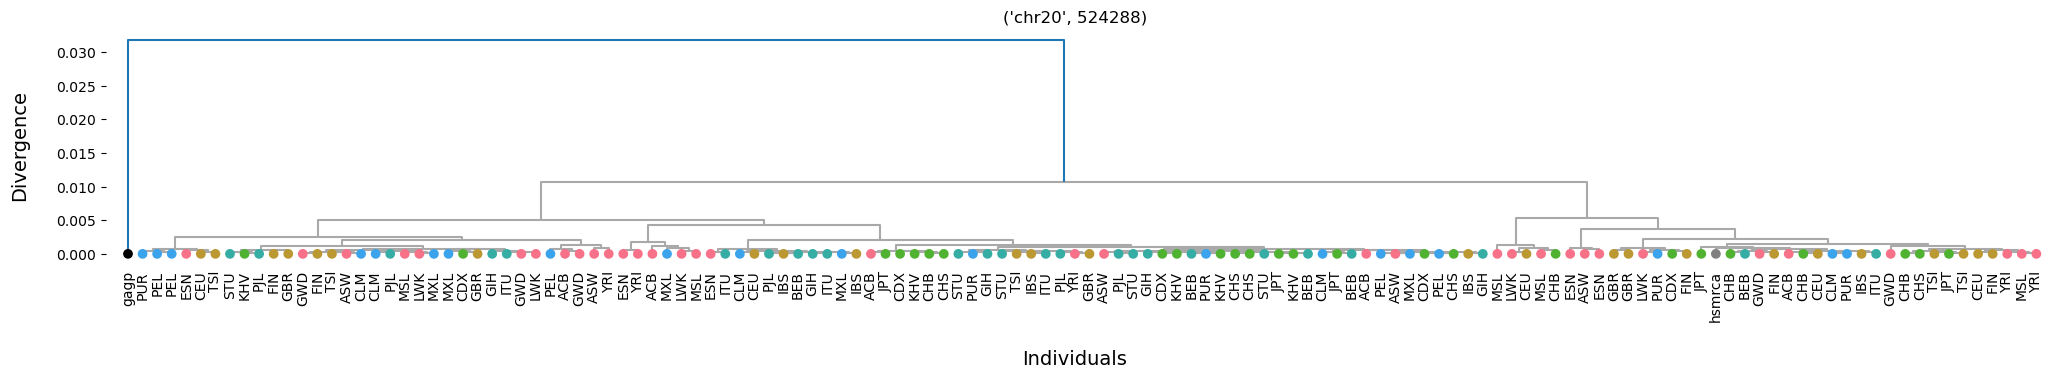

In [49]:
dendrogram = get_window_dendrogram(("chr20", 524288), idx)

### Pull windows to compare to obs/exp 3D divergence windows

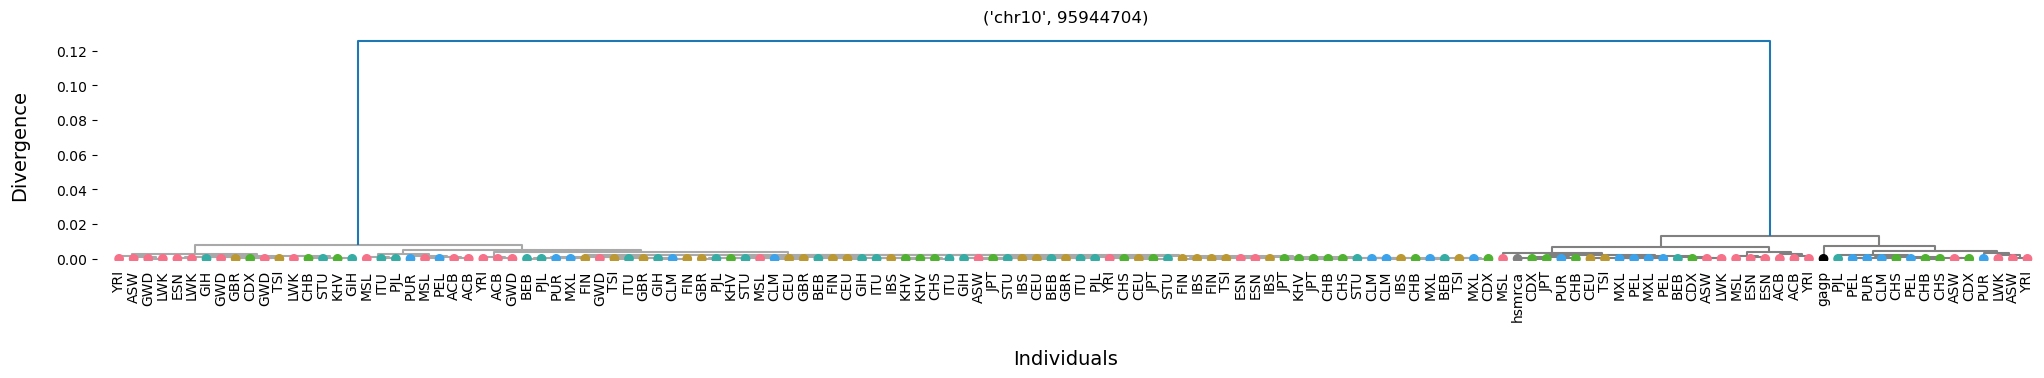

In [23]:
dendrogram = get_window_dendrogram(('chr10', 95944704), idx)

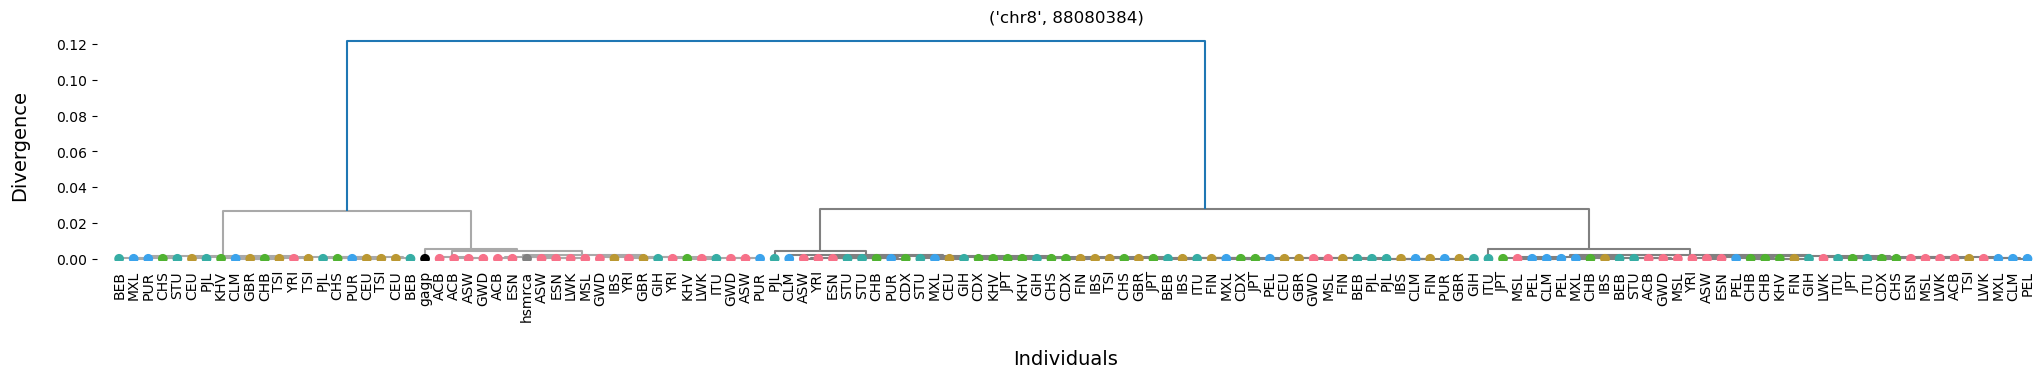

In [24]:
dendrogram = get_window_dendrogram(('chr8', 88080384), idx)

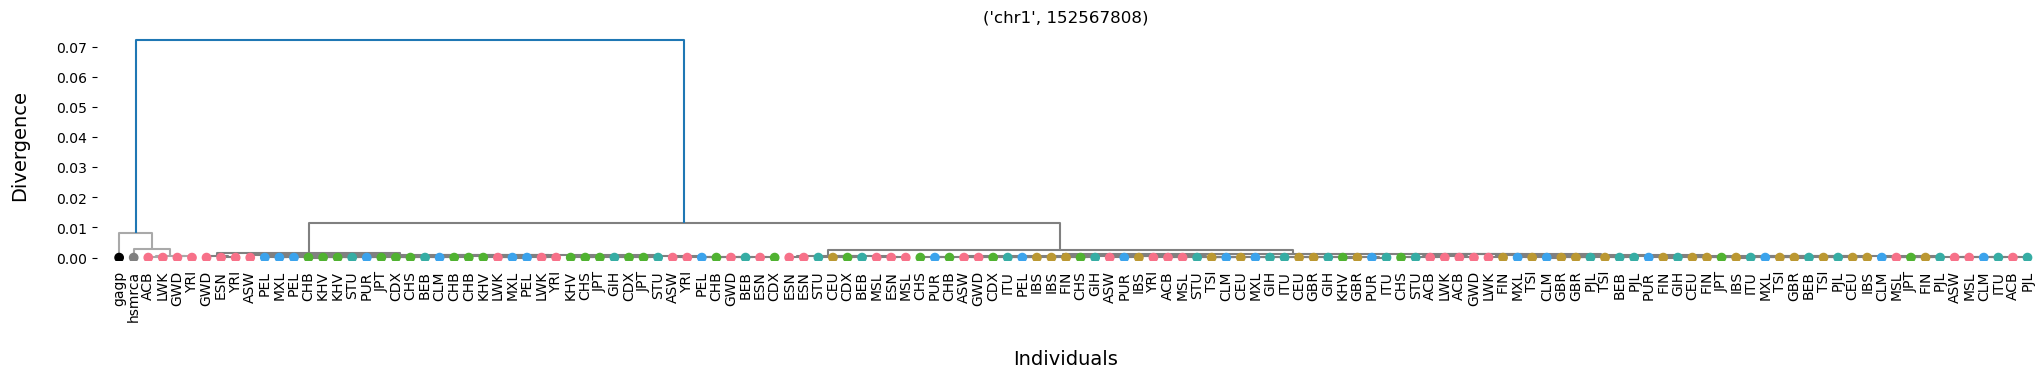

In [25]:
dendrogram = get_window_dendrogram(('chr1', 152567808), idx)

# ETE

In [74]:
trees = {}
for w in windows_tuples:
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), non_adm_ids))
    trees[w] = T


In [97]:
# length = len(idx)
# array = a.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
# condensed = array[np.triu_indices(length, k = 1)]
# Z = sch.linkage(condensed, method = 'complete')
# trees['avg'] = Tree(to_newick(hc.to_tree(Z), idx))

## Monophyletic

In [98]:
pops = {key: [] for key in ['AFR','EUR','AMR','SAS','EAS','hsmrca','gagp']}
for i in idx:
    if (i!='hsmrca') & (i!='gagp'):
        pop = i[:3]
    else:
        pop = i
    pops[pop].append(i)

In [99]:
mono = pd.DataFrame(index = windows_tuples, columns = pops.keys())

In [100]:
count = 1
for w in tree_complete.keys():
    print(count)
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    for p in pops.keys():
        status = T.check_monophyly(values=pops[p], target_attr="name")[0]
        mono.at[w,p] = status
    count += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [101]:
mono[mono.eq(True).any(1)]

AFR    EUR    AMR    SAS    EAS hsmrca   gagp
(chr1, 122683392)  True  False  False  False  False  False  False
(chr1, 123207680)  True  False  False  False  False  False  False
(chr1, 123731968)  True  False  False  False  False  False  False
(chr3, 92274688)   True  False  False  False  False  False  False
(chr5, 47710208)   True  False  False  False  False  False  False
(chr5, 48234496)   True  False  False  False  False  False  False
(chr9, 43515904)   True  False  False  False  False  False  False
(chr12, 35127296)  True  False  False  False  False  False  False
(chr17, 23592960)  True  False  False  False  False  False  False
(chr17, 24117248)  True  False  False  False  False  False  False
(chr18, 17301504)  True  False  False  False  False  False  False
(chr18, 19398656)  True  False  False  False  False  False  False
(chr19, 25165824)  True  False  False  False  False  False  False
(chr19, 25690112)  True  False  False  False  False  False  False

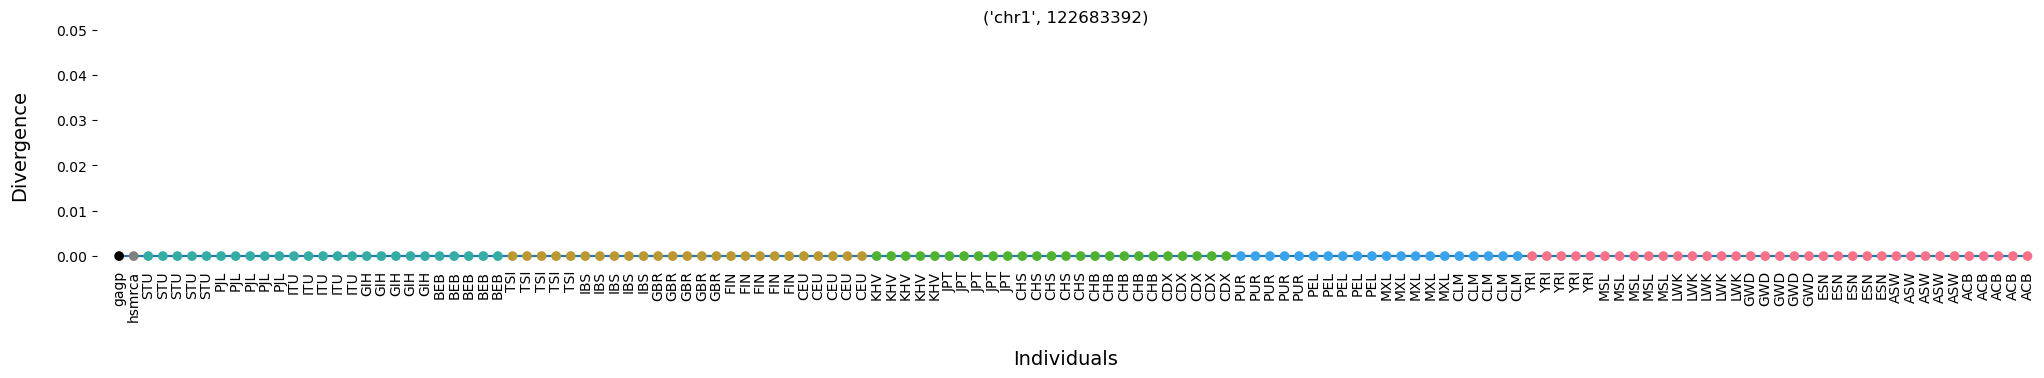

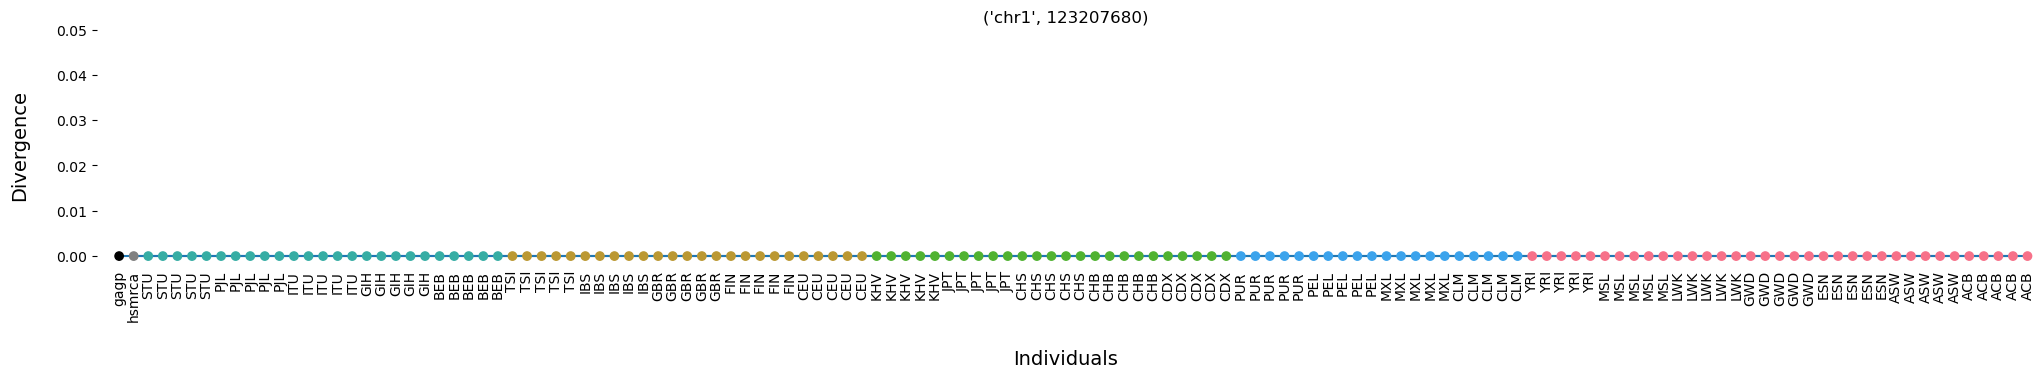

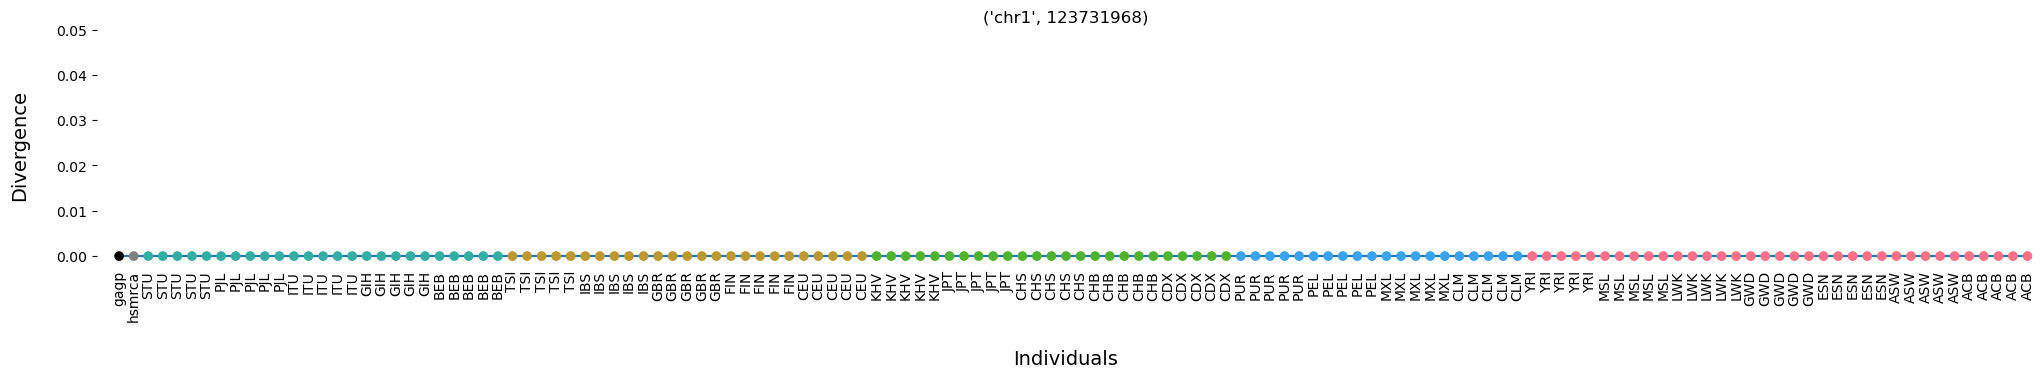

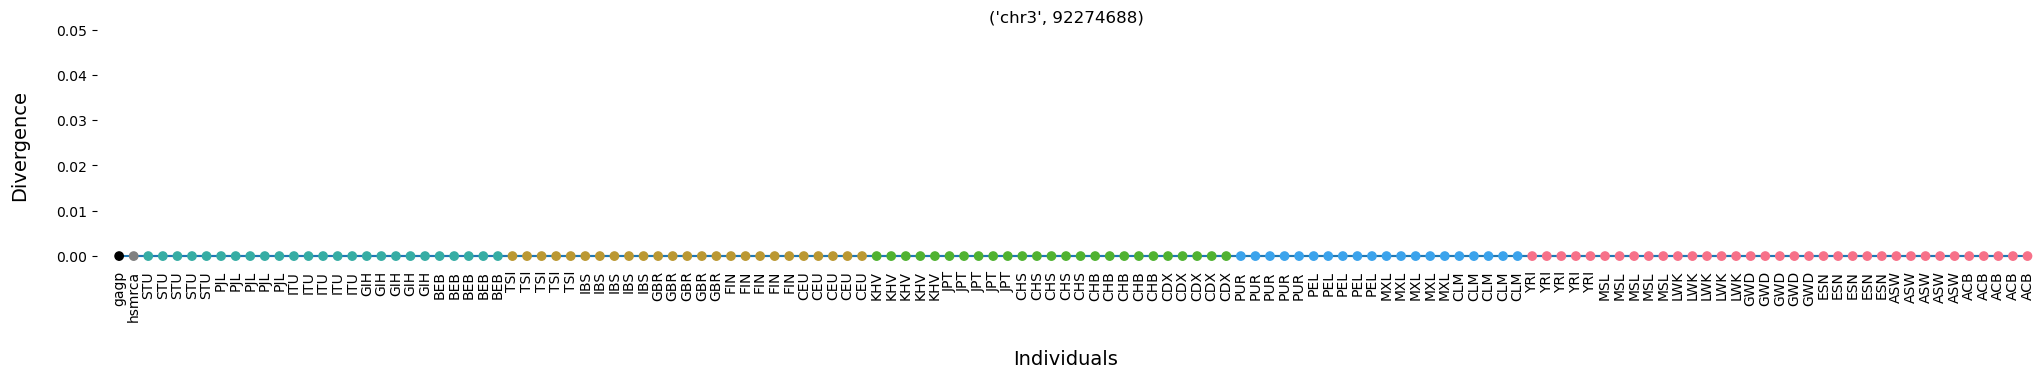

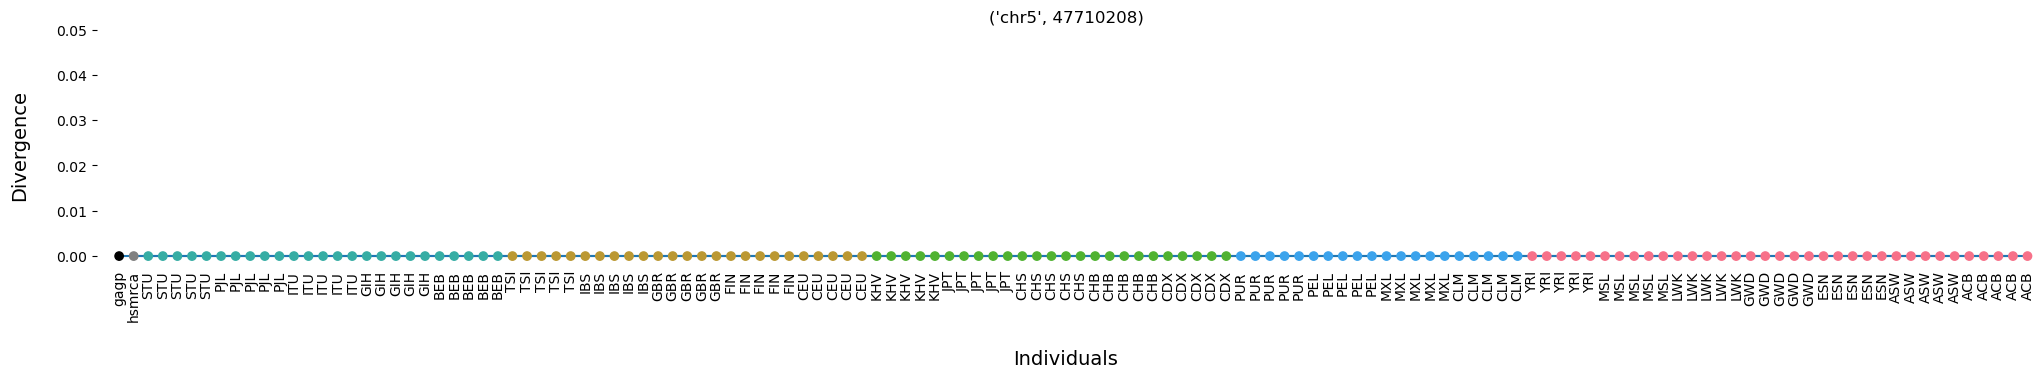

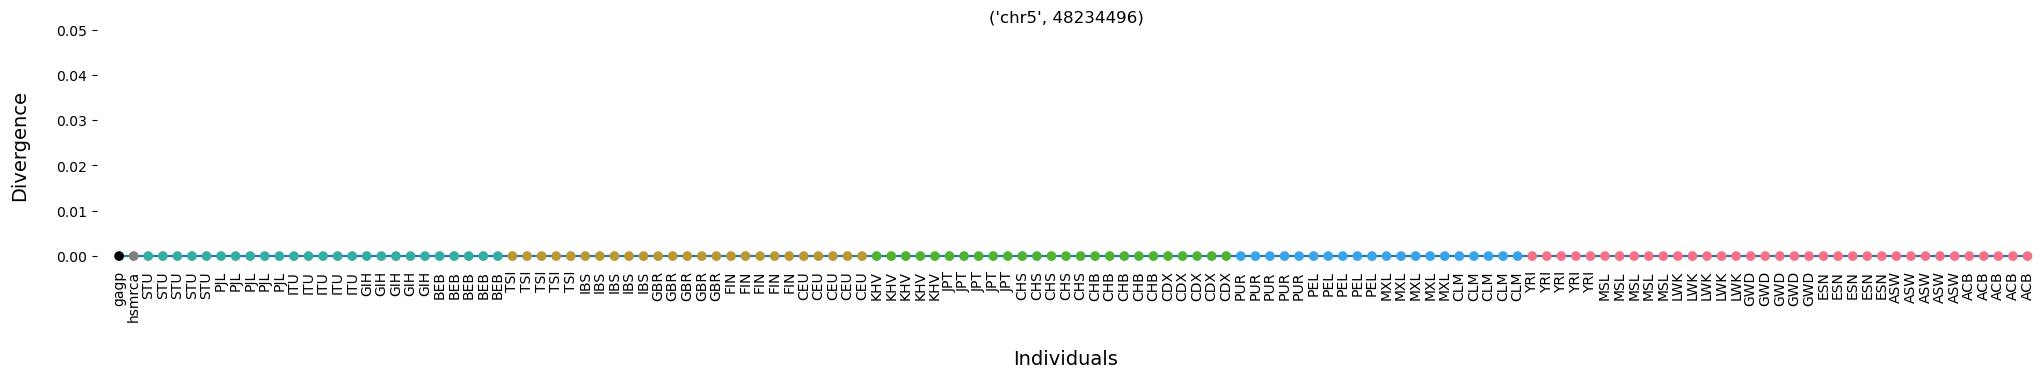

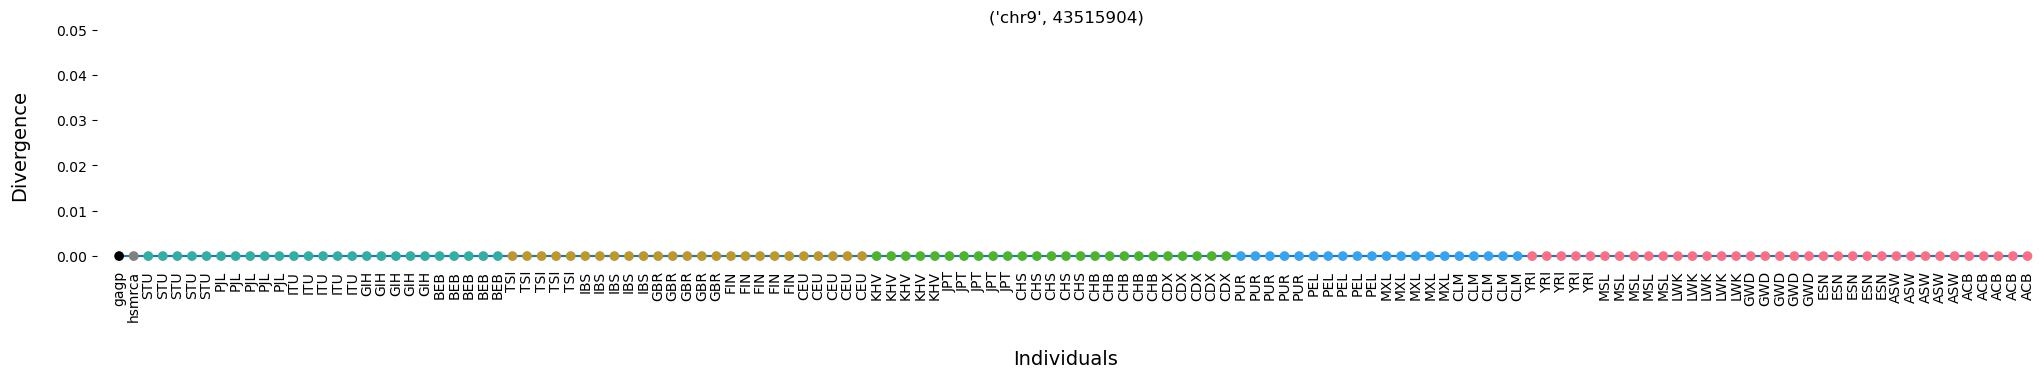

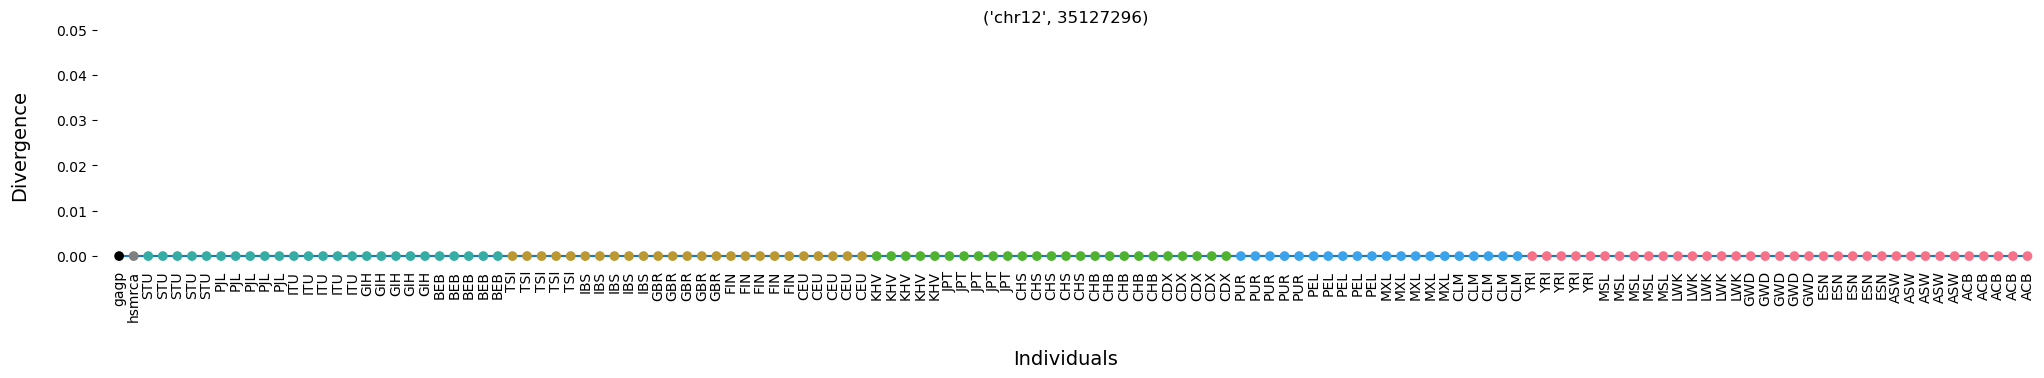

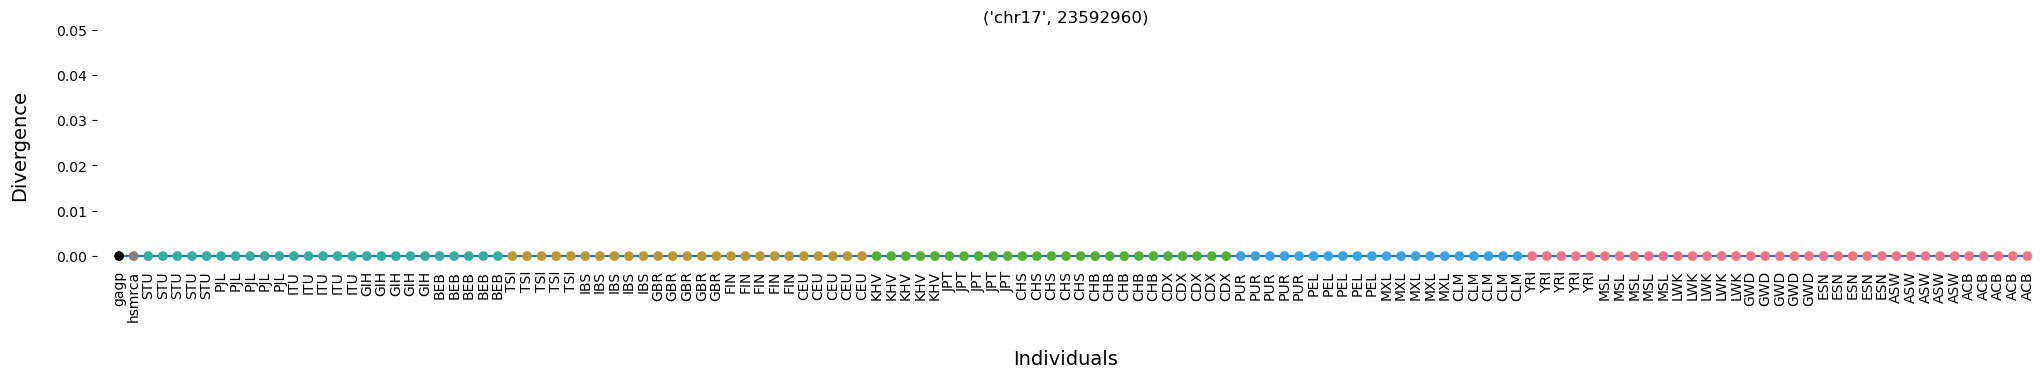

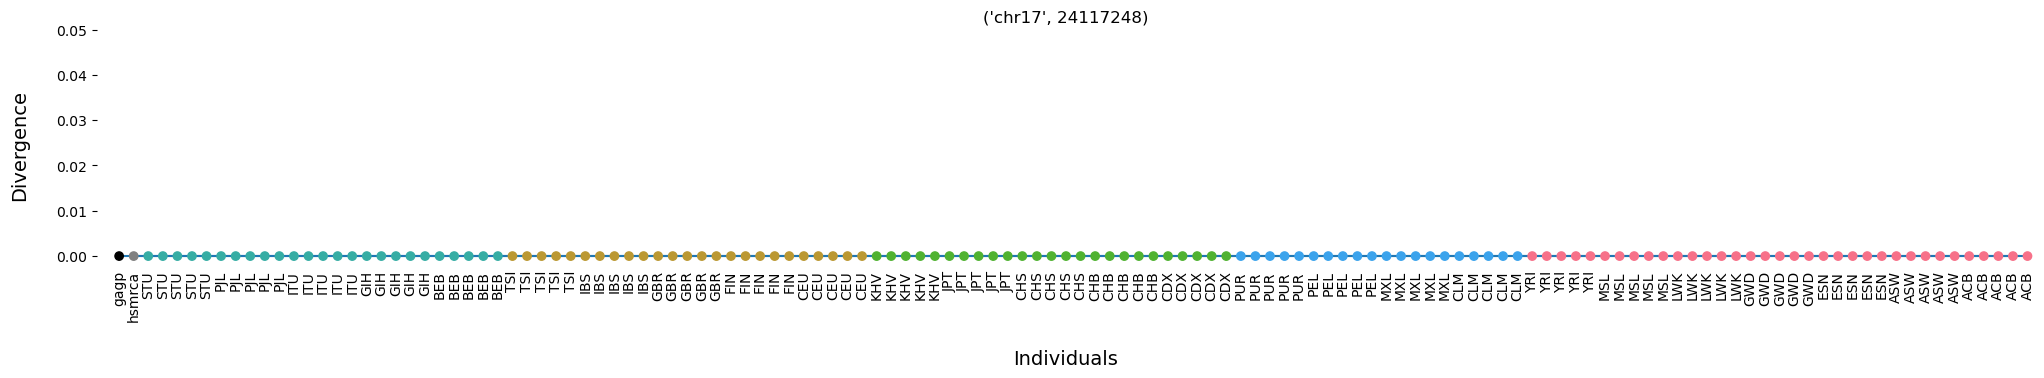

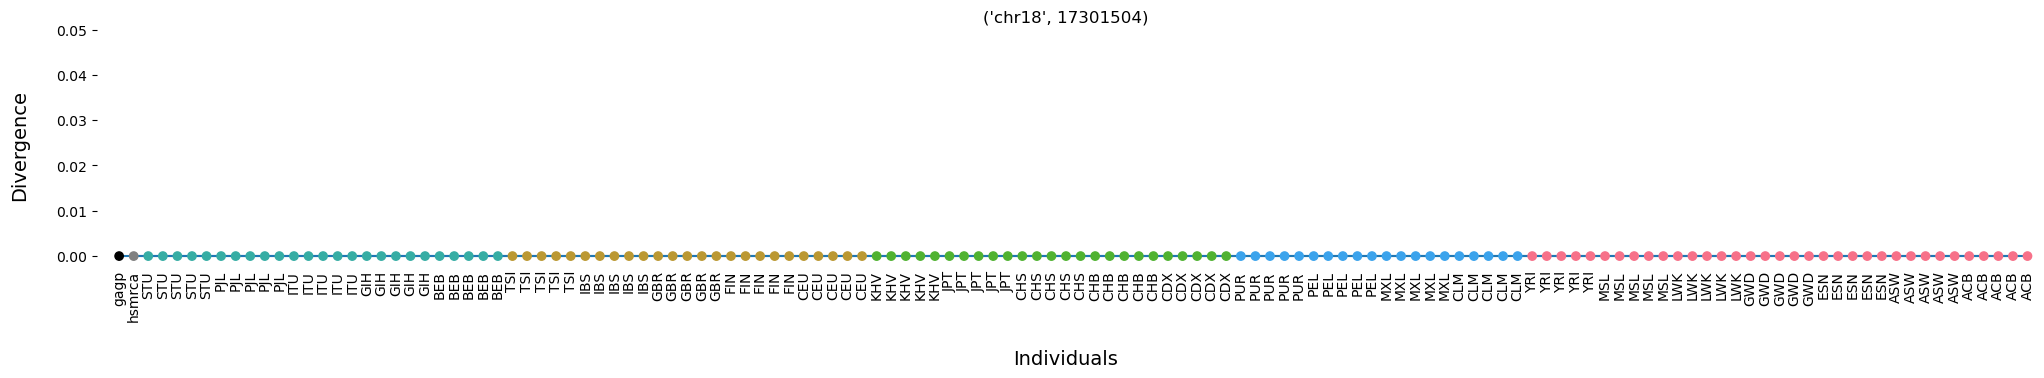

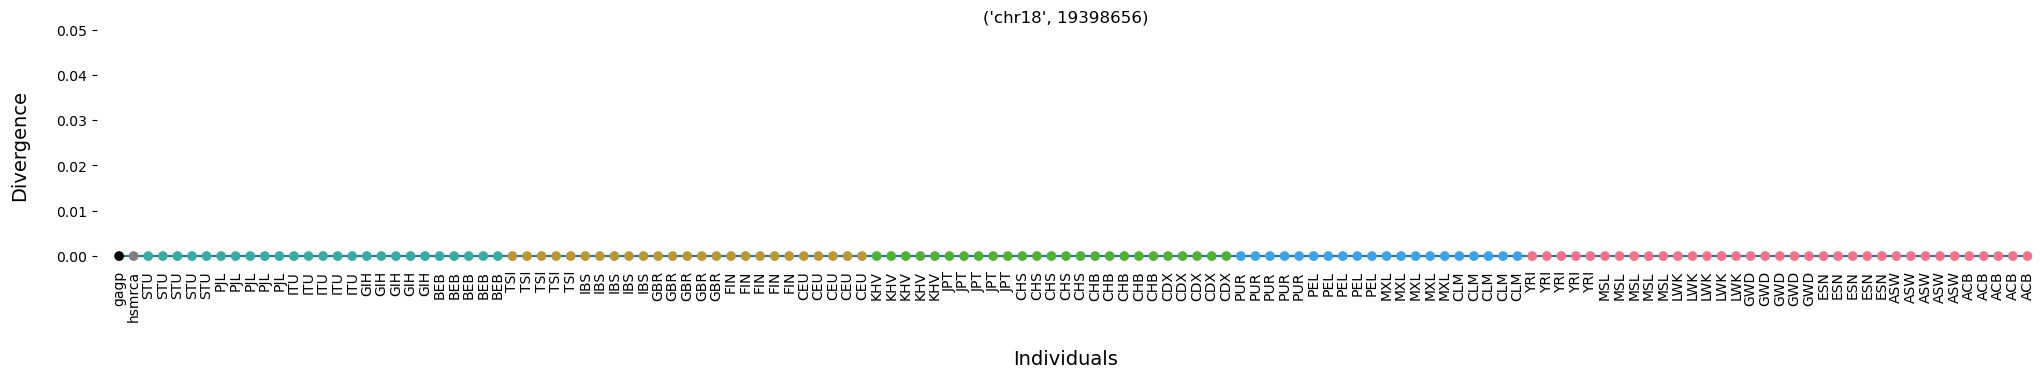

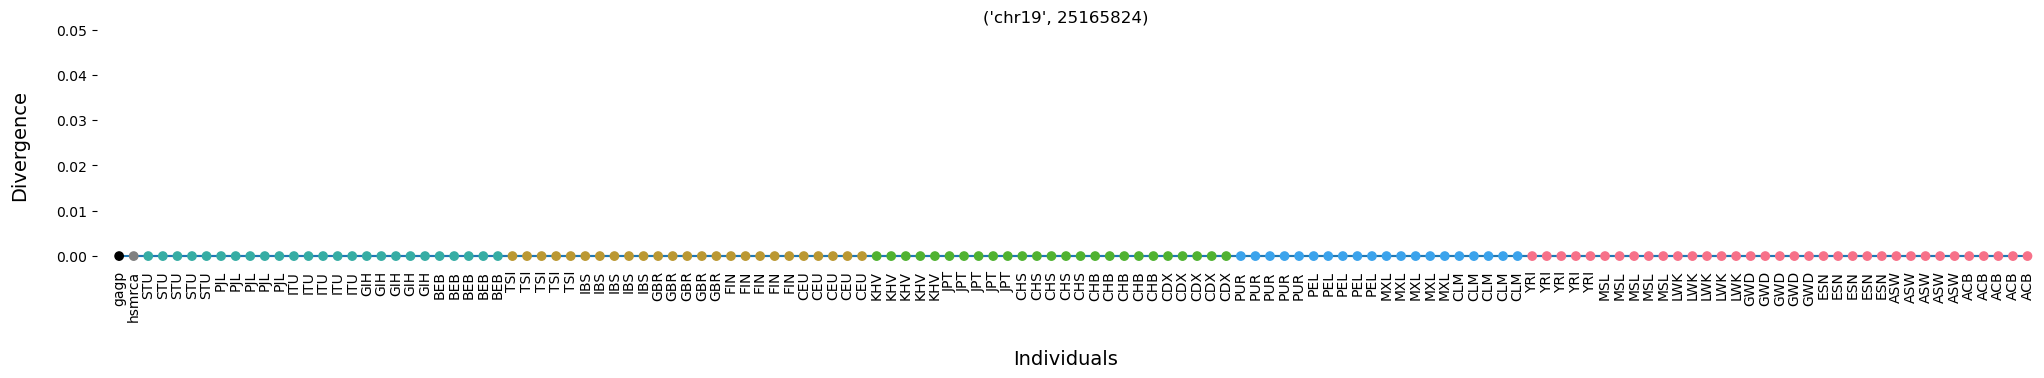

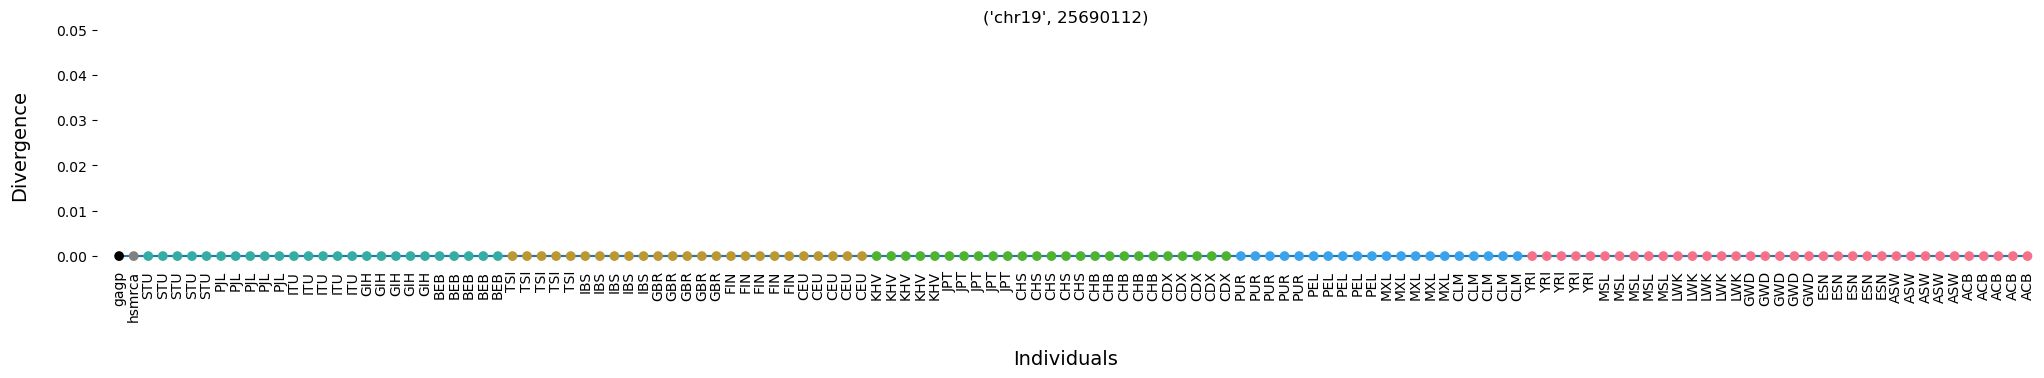

In [102]:
for w in mono[mono.eq(True).any(1)].index:
    get_window_dendrogram(w,idx)

In [104]:
sub_pops = {key: [] for key in sub_idx}
for i in idx:
    if (i != 'hsmrca') & (i!='gagp'):
        pop = i[4:7]
    else:
        pop = i
    sub_pops[pop].append(i)

In [105]:
sub_mono = pd.DataFrame(index = windows_tuples, columns = sub_pops.keys())
count = 0
for w in tree_complete.keys():
    if count%100 == 0:
        print(count)
    Z = tree_complete[w][0]
    T = Tree(to_newick(hc.to_tree(Z), idx))
    for p in sub_pops.keys():
        status = T.check_monophyly(values=sub_pops[p], target_attr="name")[0]
        sub_mono.at[w,p] = status
    count += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


In [106]:
sub_mono[sub_mono.eq(True).any(1)]

ACB    ASW    ESN    GWD    LWK    MSL    YRI    CLM  \
(chr1, 122683392)   True  False  False  False  False  False  False  False   
(chr1, 123207680)   True  False  False  False  False  False  False  False   
(chr1, 123731968)   True  False  False  False  False  False  False  False   
(chr3, 92274688)    True  False  False  False  False  False  False  False   
(chr5, 47710208)    True  False  False  False  False  False  False  False   
(chr5, 48234496)    True  False  False  False  False  False  False  False   
(chr9, 43515904)    True  False  False  False  False  False  False  False   
(chr12, 35127296)   True  False  False  False  False  False  False  False   
(chr17, 23592960)   True  False  False  False  False  False  False  False   
(chr17, 24117248)   True  False  False  False  False  False  False  False   
(chr18, 17301504)   True  False  False  False  False  False  False  False   
(chr18, 19398656)   True  False  False  False  False  False  False  False   
(chr19, 25165824)   True  False  False  False  False  False  False  False   
(chr19, 25690112)   True  False  False  False  False  False  False  False   
(chr21, 44564480)  False  False  False  False  False  False  False  False   

                     MXL    PEL  ...    GBR    IBS    TSI    BEB    GIH  \
(chr1, 122683392)  False  False  ...  False  False  False  False  False   
(chr1, 123207680)  False  False  ...  False  False  False  False  False   
(chr1, 123731968)  False  False  ...  False  False  False  False  False   
(chr3, 92274688)   False  False  ...  False  False  False  False  False   
(chr5, 47710208)   False  False  ...  False  False  False  False  False   
(chr5, 48234496)   False  False  ...  False  False  False  False  False   
(chr9, 43515904)   False  False  ...  False  False  False  False  False   
(chr12, 35127296)  False  False  ...  False  False  False  False  False   
(chr17, 23592960)  False  False  ...  False  False  False  False  False   
(chr17, 24117248)  False  False  ...  False  False  False  False  False   
(chr18, 17301504)  False  False  ...  False  False  False  False  False   
(chr18, 19398656)  False  False  ...  False  False  False  False  False   
(chr19, 25165824)  False  False  ...  False  False  False  False  False   
(chr19, 25690112)  False  False  ...  False  False  False  False  False   
(chr21, 44564480)  False   True  ...  False  False  False  False  False   

                     ITU    PJL    STU hsmrca   gagp  
(chr1, 122683392)  False  False  False  False  False  
(chr1, 123207680)  False  False  False  False  False  
(chr1, 123731968)  False  False  False  False  False  
(chr3, 92274688)   False  False  False  False  False  
(chr5, 47710208)   False  False  False  False  False  
(chr5, 48234496)   False  False  False  False  False  
(chr9, 43515904)   False  False  False  False  False  
(chr12, 35127296)  False  False  False  False  False  
(chr17, 23592960)  False  False  False  False  False  
(chr17, 24117248)  False  False  False  False  False  
(chr18, 17301504)  False  False  False  False  False  
(chr18, 19398656)  False  False  False  False  False  
(chr19, 25165824)  False  False  False  False  False  
(chr19, 25690112)  False  False  False  False  False  
(chr21, 44564480)  False  False  False  False  False  

[15 rows x 28 columns]

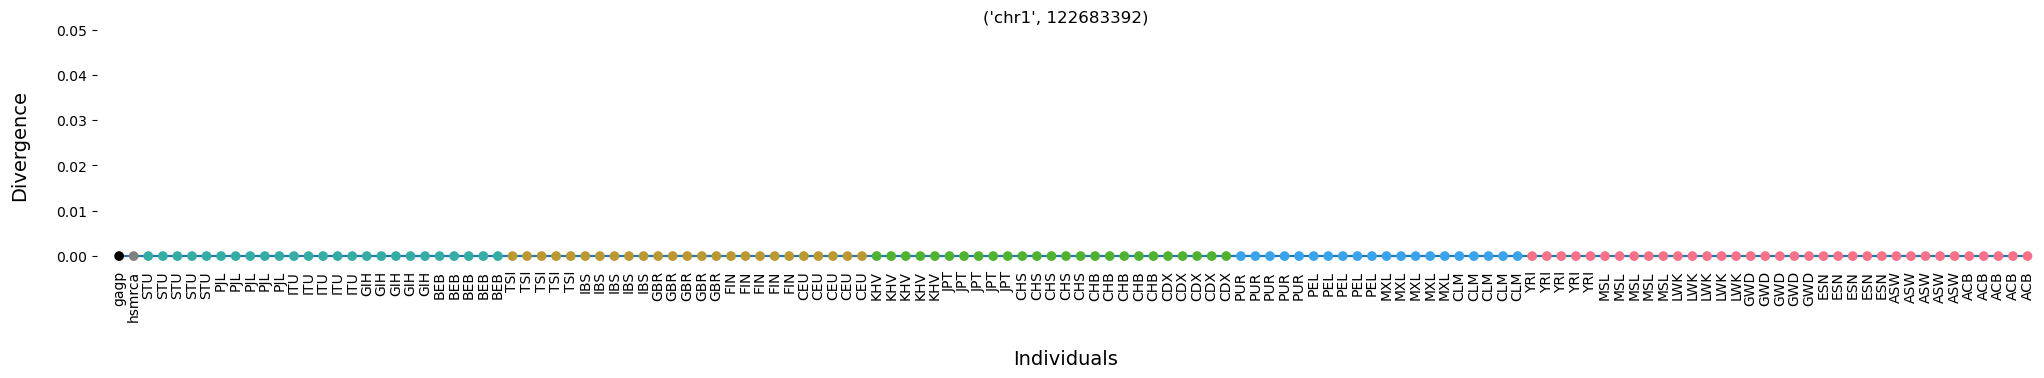

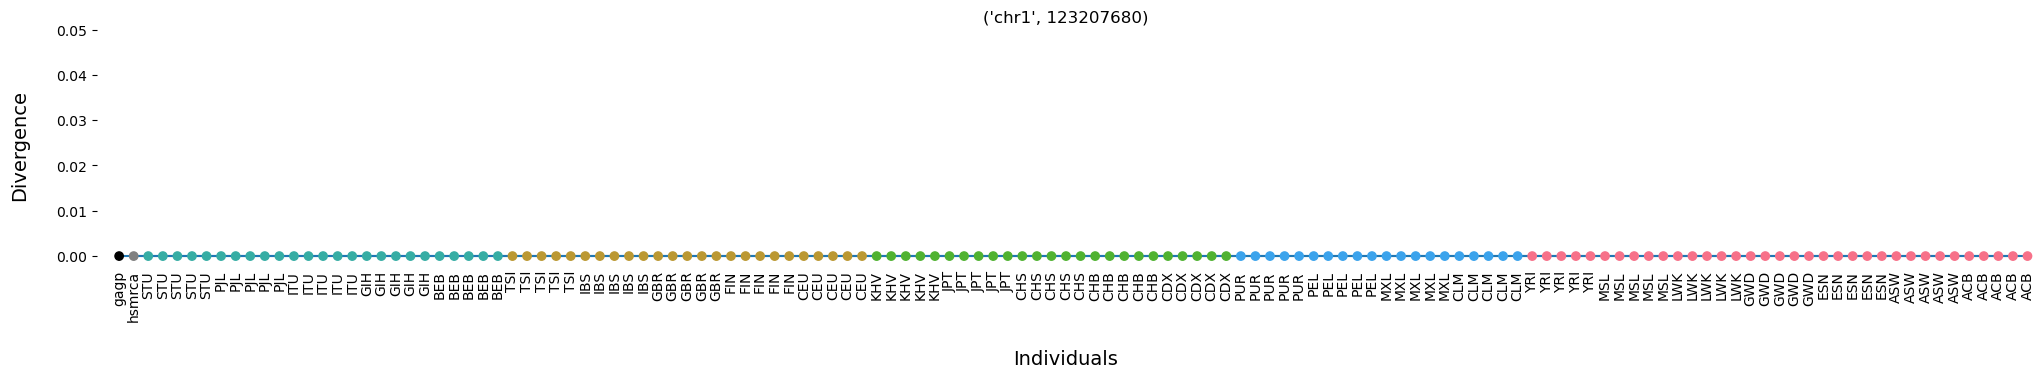

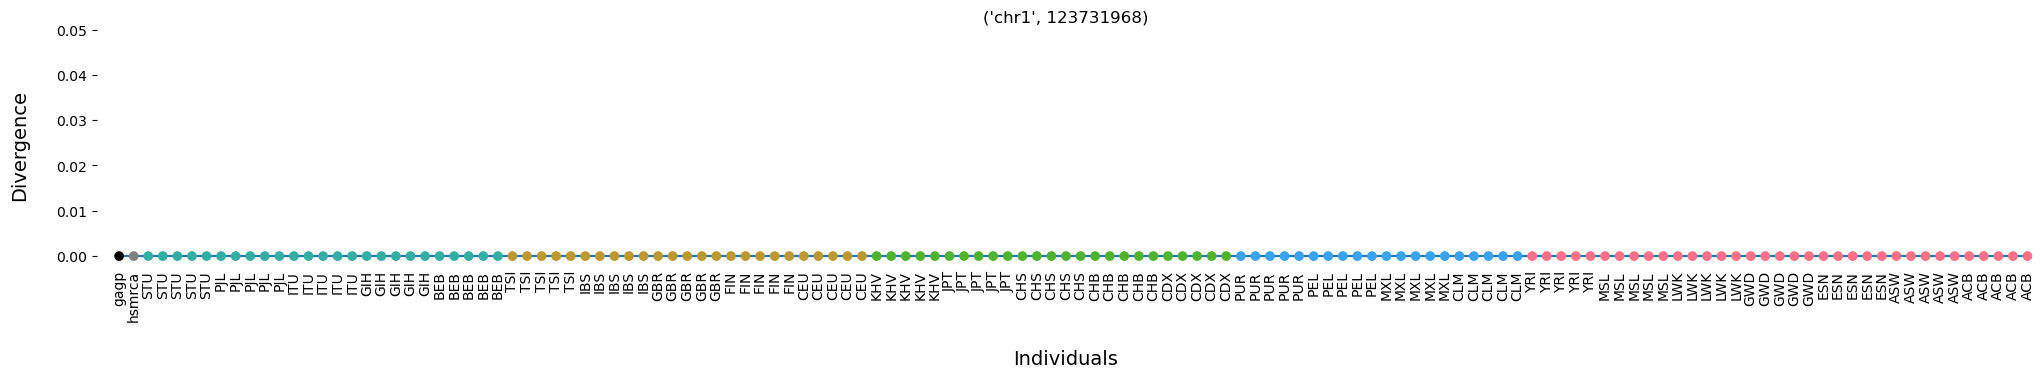

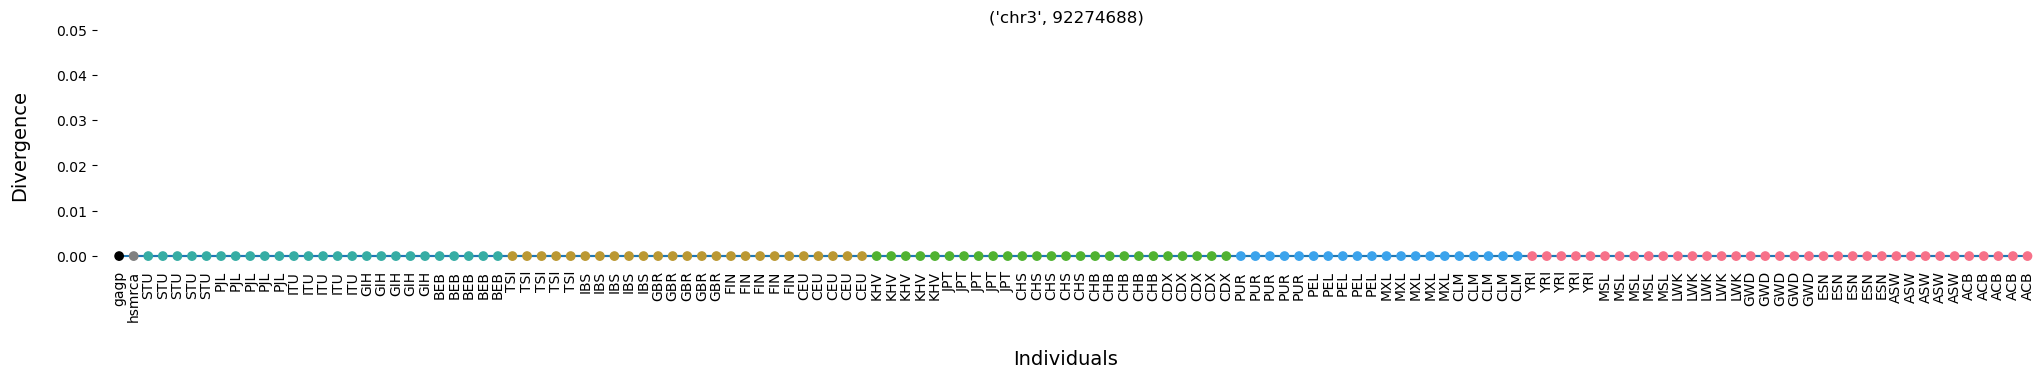

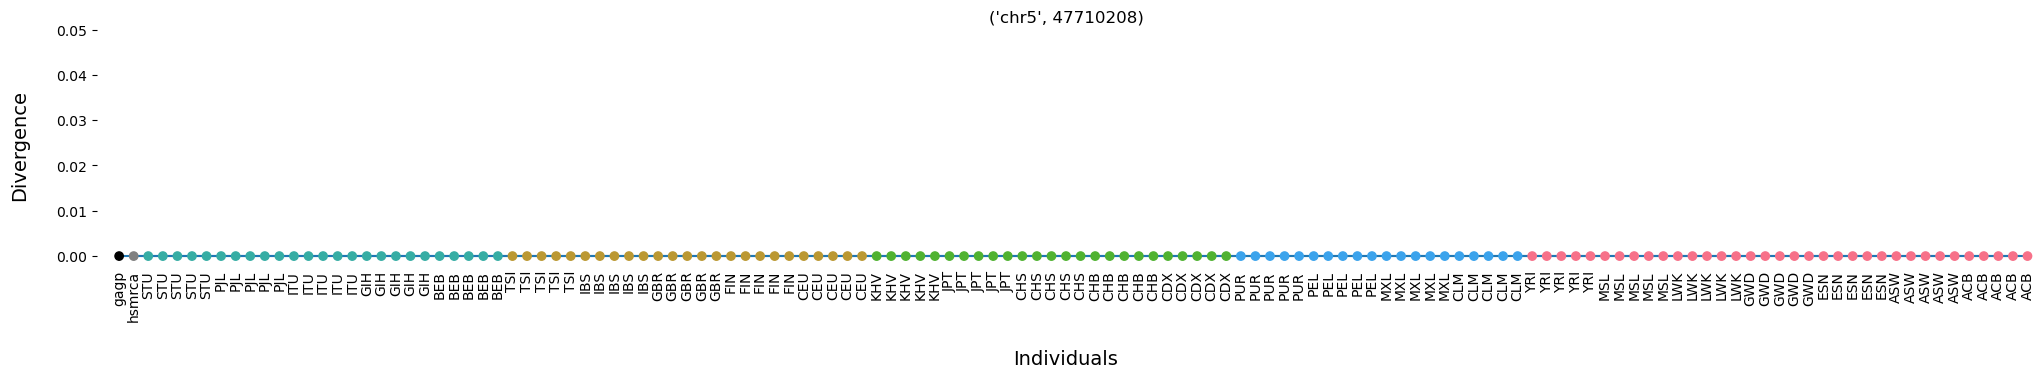

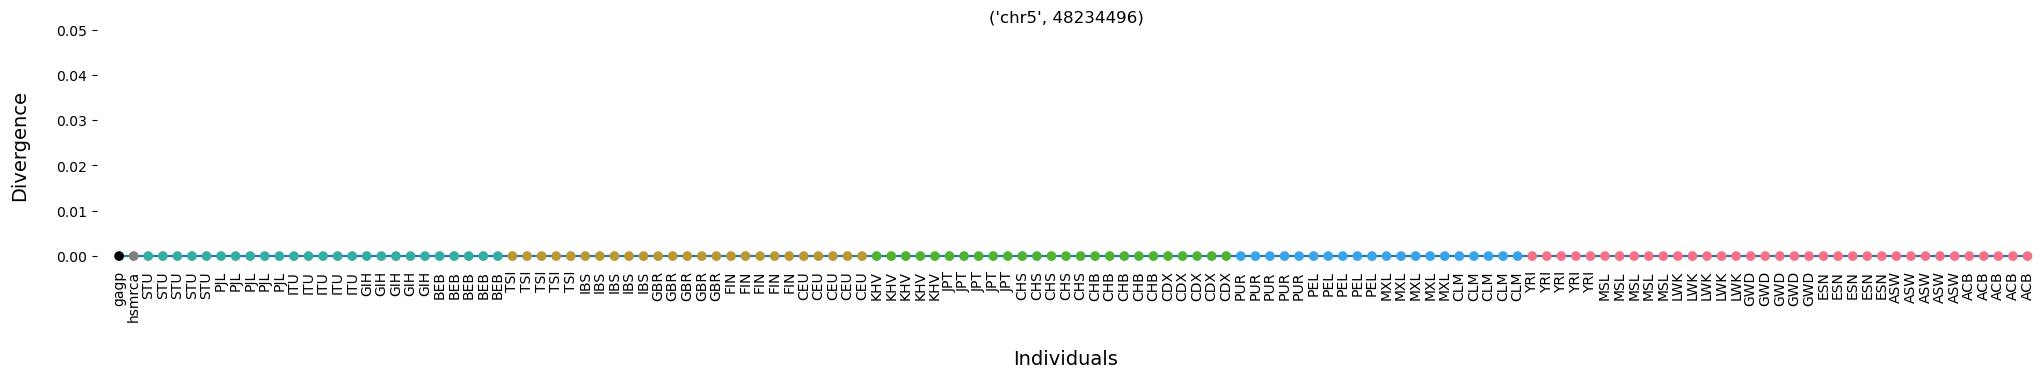

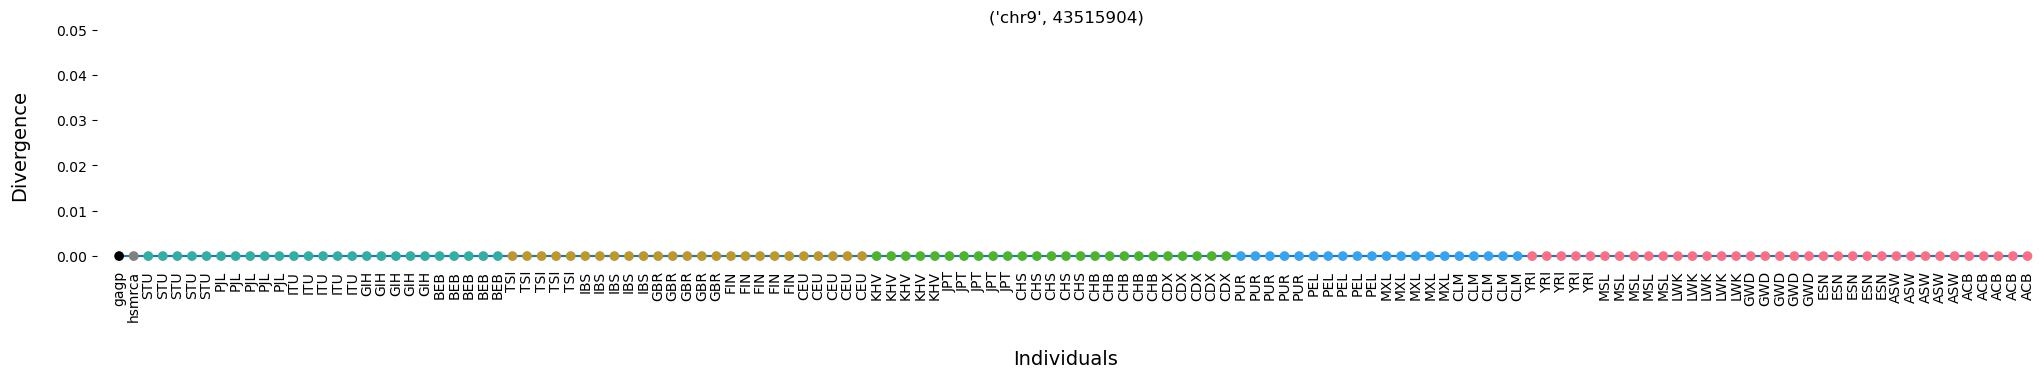

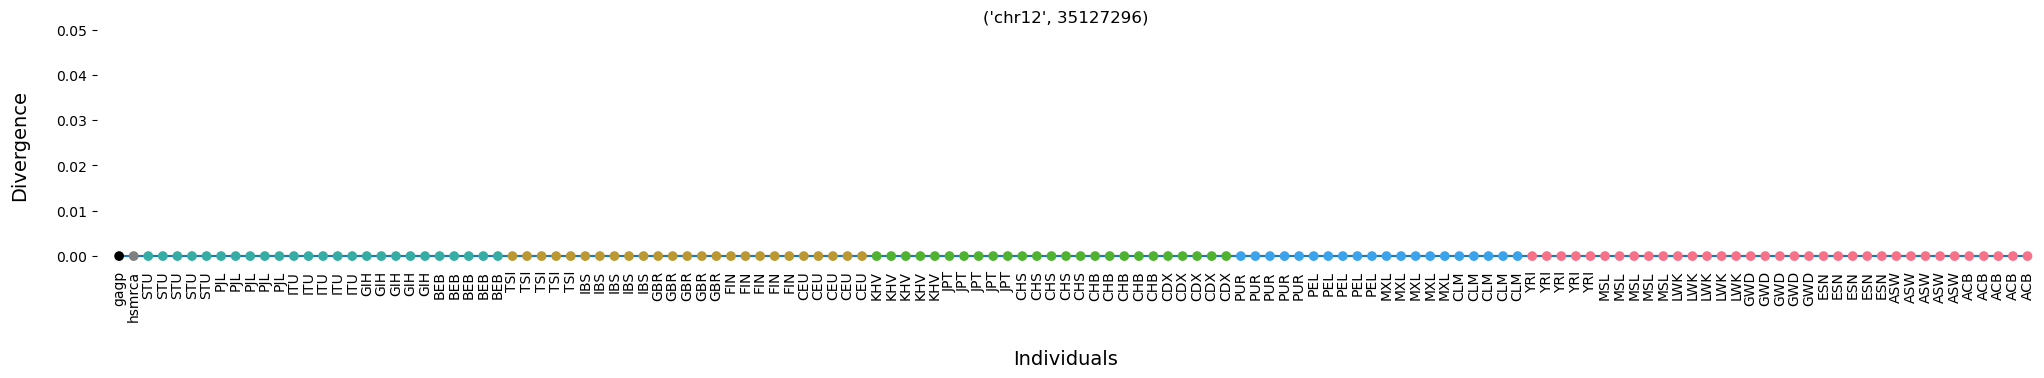

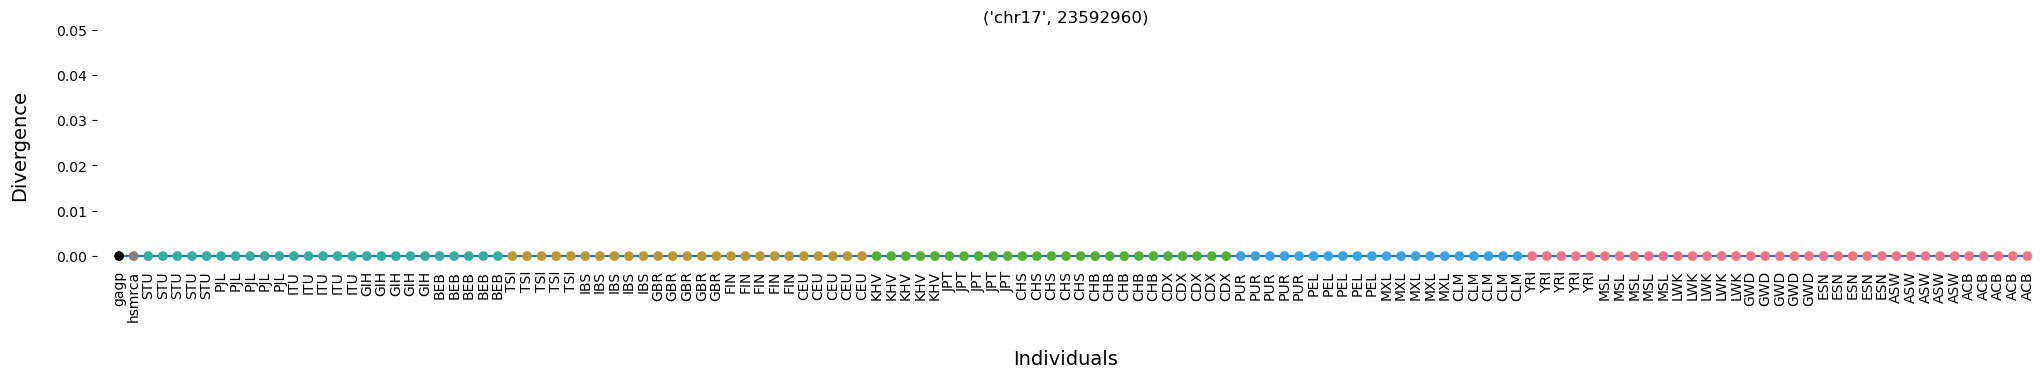

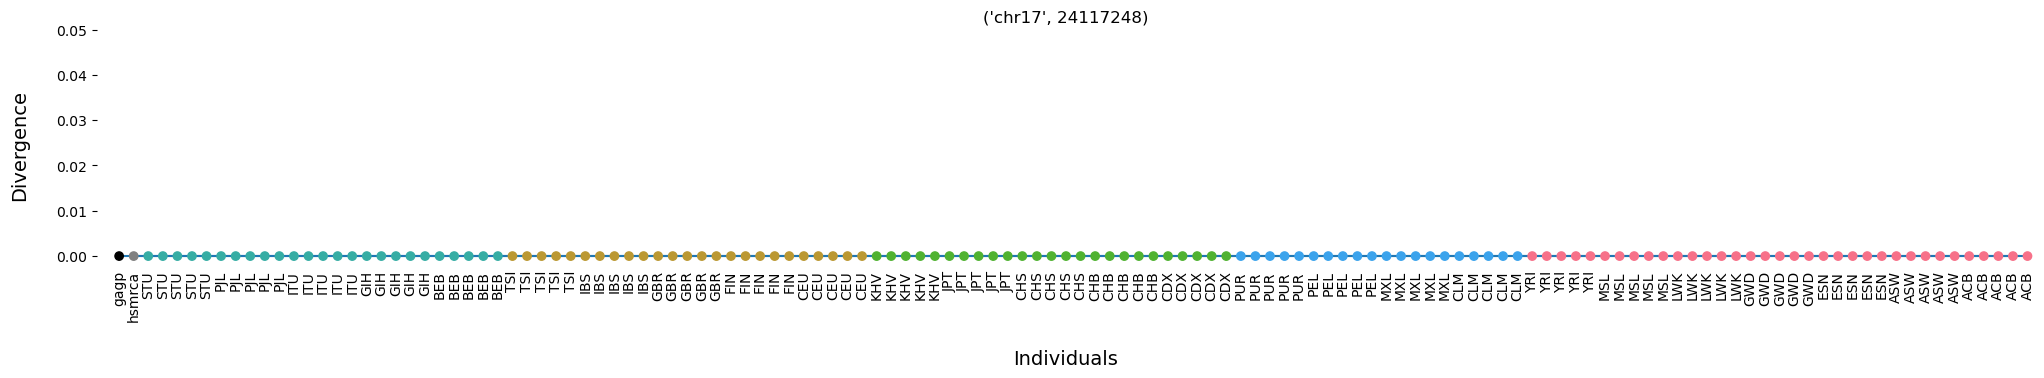

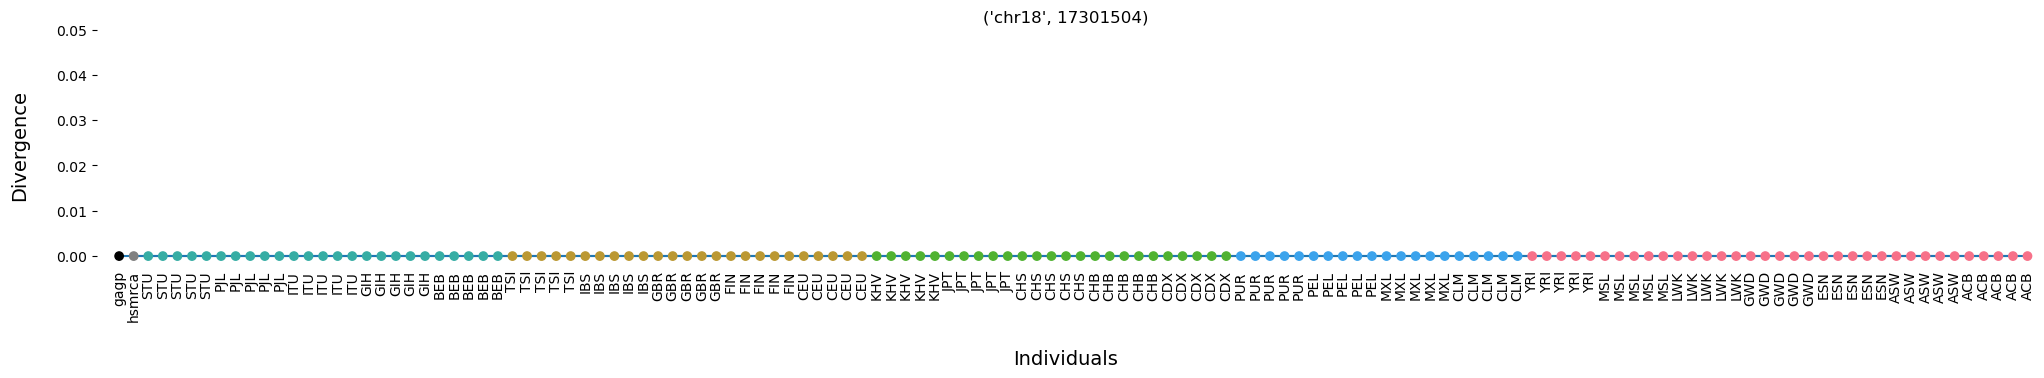

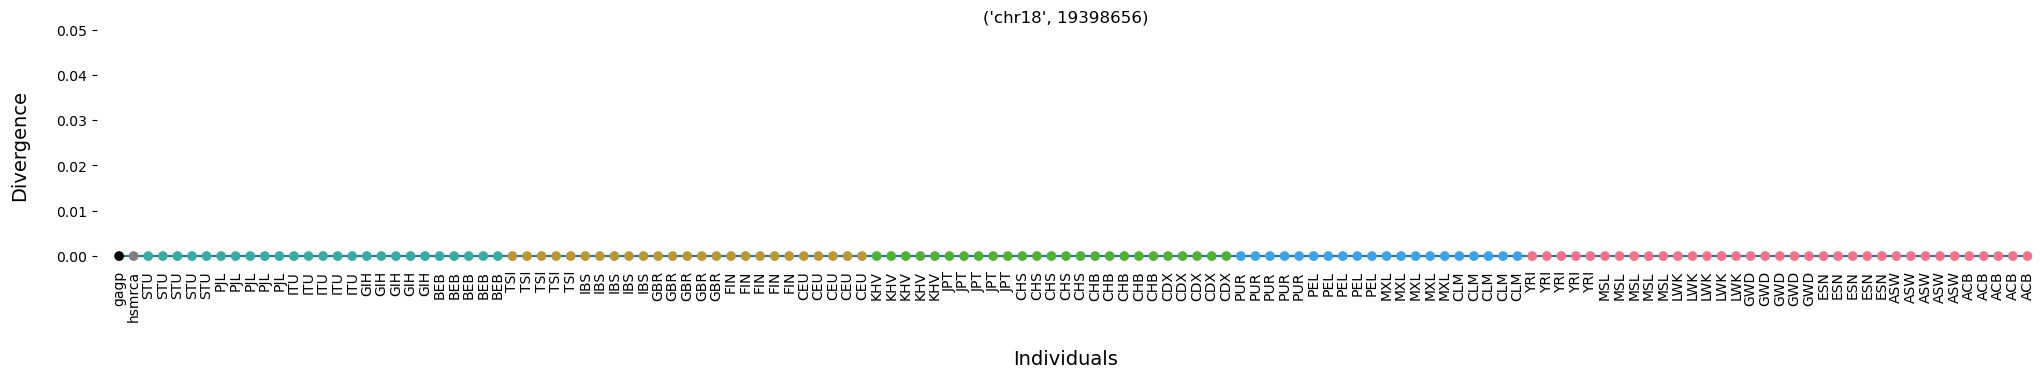

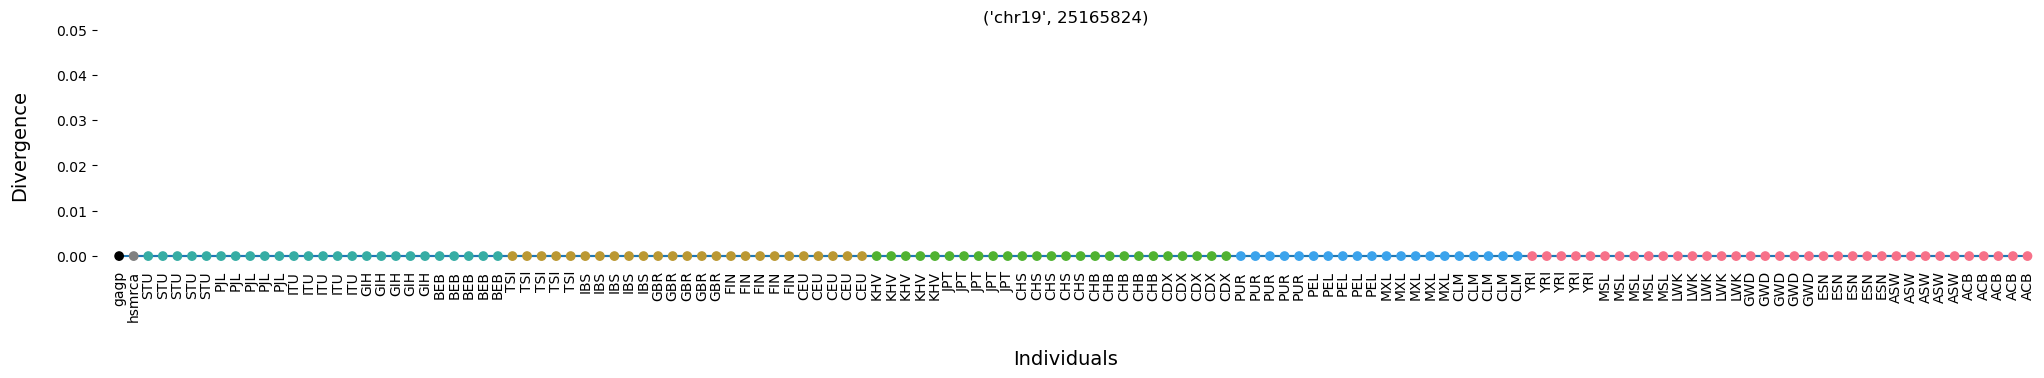

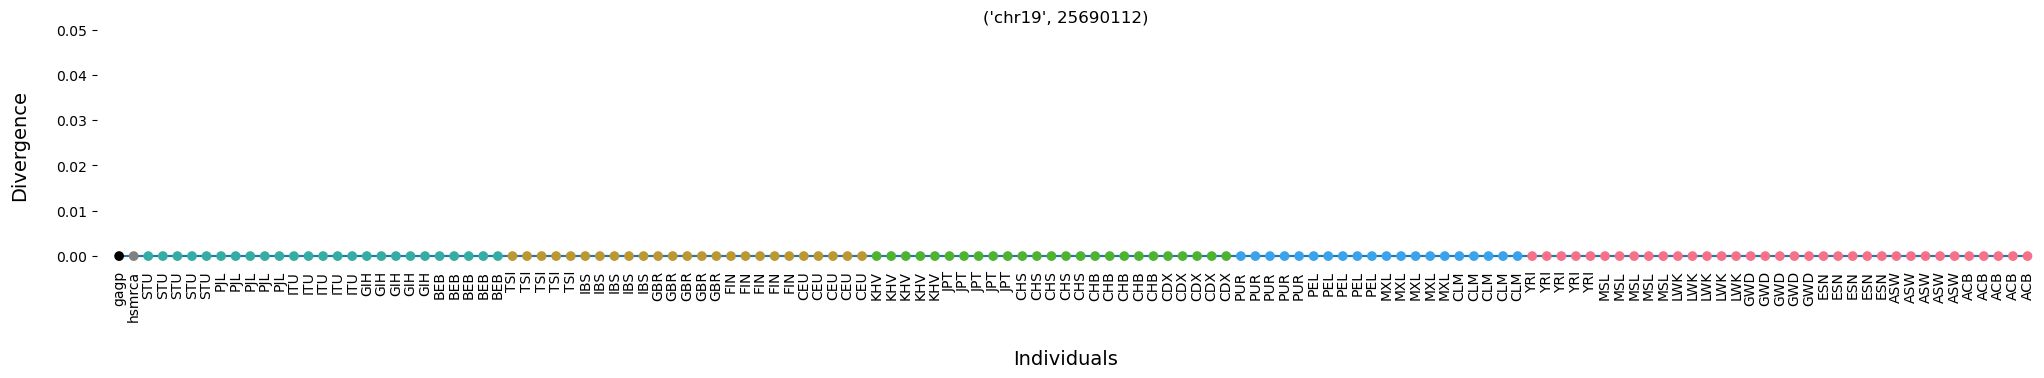

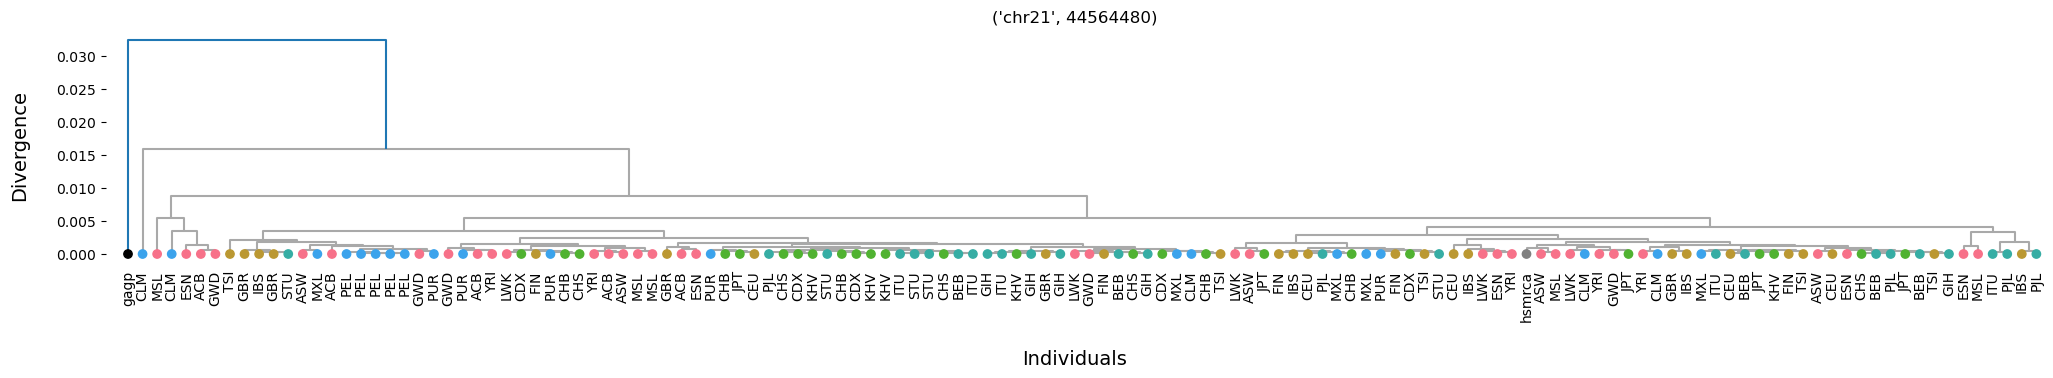

In [107]:
for w in sub_mono[sub_mono.eq(True).any(1)].index:
    get_window_dendrogram(w,idx)

In [108]:
trees['avg']

Tree node '' (0x7f908d693a3)

## compare trees

### Genome Average 3D tree

In [109]:
tree_comp_stats = pd.DataFrame(columns=['rf','max_rf','norm_rf','ref_edges_in_source','source_edges_in_ref'])
for w in trees.keys():
    if w != 'avg':
        comp = trees['avg'].compare(trees[w])
        rf = comp['rf']
        max_rf = comp['max_rf']
        norm = comp['norm_rf']
        rs = comp['ref_edges_in_source']
        sr = comp['source_edges_in_ref']
        
        tmp = pd.Series([rf, max_rf, norm, rs, sr], name=w, index=['rf','max_rf','norm_rf','ref_edges_in_source','source_edges_in_ref'])
        tree_comp_stats = tree_comp_stats.append(tmp)

<Axes: >

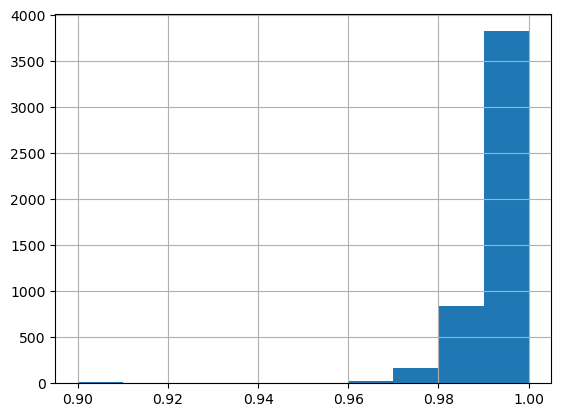

In [110]:
tree_comp_stats.norm_rf.hist()

<Axes: >

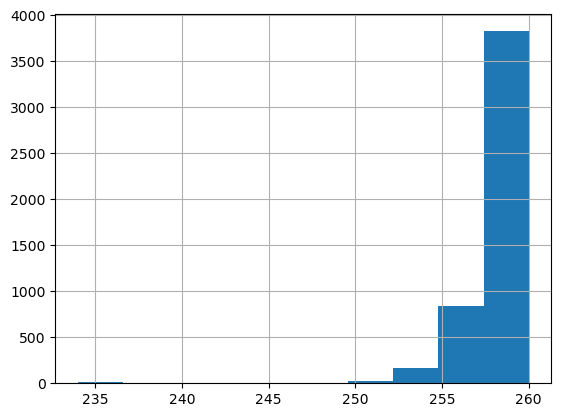

In [111]:
tree_comp_stats.rf.hist()

<Axes: >

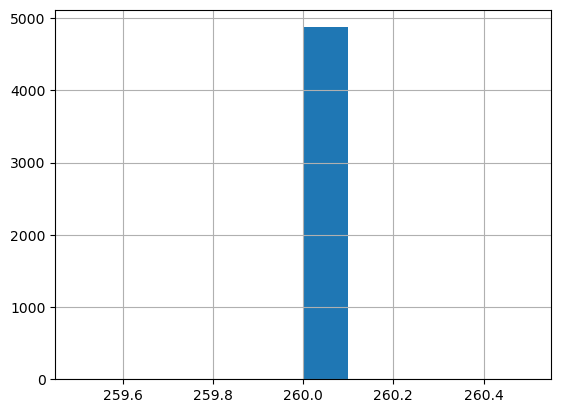

In [112]:
tree_comp_stats.max_rf.hist()

<Axes: >

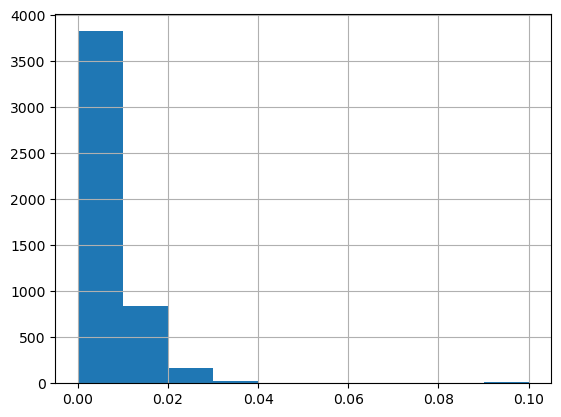

In [113]:
tree_comp_stats.ref_edges_in_source.hist()

<Axes: >

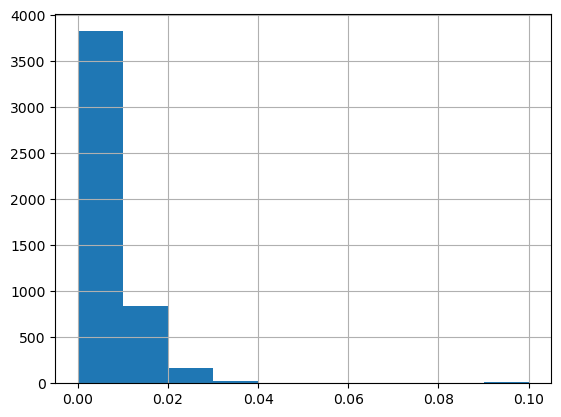

In [114]:
tree_comp_stats.source_edges_in_ref.hist()

In [119]:
tree_comp_stats.sort_values(by=['norm_rf']).head(n=15)

rf  max_rf   norm_rf  ref_edges_in_source  \
(chr1, 122683392)  234.0   260.0  0.900000             0.100000   
(chr5, 47710208)   234.0   260.0  0.900000             0.100000   
(chr5, 48234496)   234.0   260.0  0.900000             0.100000   
(chr18, 17301504)  234.0   260.0  0.900000             0.100000   
(chr3, 92274688)   234.0   260.0  0.900000             0.100000   
(chr18, 19398656)  234.0   260.0  0.900000             0.100000   
(chr17, 24117248)  234.0   260.0  0.900000             0.100000   
(chr19, 25165824)  234.0   260.0  0.900000             0.100000   
(chr9, 43515904)   234.0   260.0  0.900000             0.100000   
(chr17, 23592960)  234.0   260.0  0.900000             0.100000   
(chr12, 35127296)  234.0   260.0  0.900000             0.100000   
(chr1, 123207680)  234.0   260.0  0.900000             0.100000   
(chr19, 25690112)  234.0   260.0  0.900000             0.100000   
(chr1, 123731968)  234.0   260.0  0.900000             0.100000   
(chr21, 14680064)  250.0   260.0  0.961538             0.038462   

                   source_edges_in_ref  
(chr1, 122683392)             0.100000  
(chr5, 47710208)              0.100000  
(chr5, 48234496)              0.100000  
(chr18, 17301504)             0.100000  
(chr3, 92274688)              0.100000  
(chr18, 19398656)             0.100000  
(chr17, 24117248)             0.100000  
(chr19, 25165824)             0.100000  
(chr9, 43515904)              0.100000  
(chr17, 23592960)             0.100000  
(chr12, 35127296)             0.100000  
(chr1, 123207680)             0.100000  
(chr19, 25690112)             0.100000  
(chr1, 123731968)             0.100000  
(chr21, 14680064)             0.038462

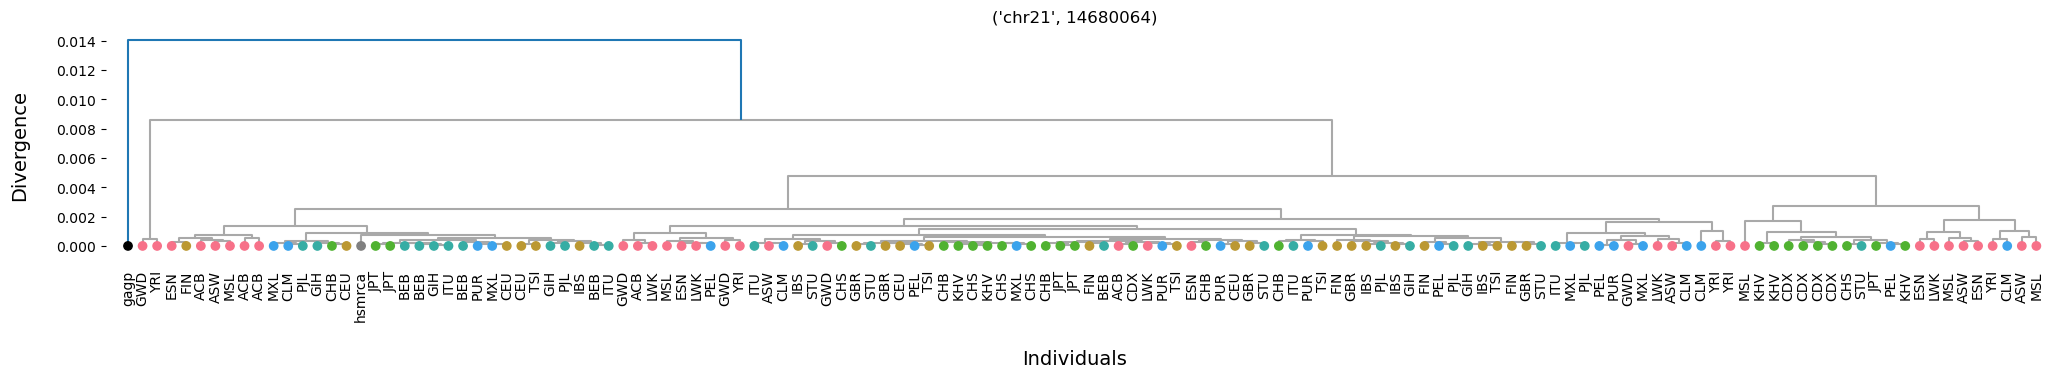

array([[9.60000000e+01, 1.02000000e+02, 6.30263887e-05, 2.00000000e+00],
       [4.60000000e+01, 5.30000000e+01, 7.76914476e-05, 2.00000000e+00],
       [6.80000000e+01, 7.50000000e+01, 8.56393669e-05, 2.00000000e+00],
       [4.70000000e+01, 1.00000000e+02, 8.71926929e-05, 2.00000000e+00],
       [7.10000000e+01, 7.40000000e+01, 8.77858147e-05, 2.00000000e+00],
       [1.09000000e+02, 1.15000000e+02, 9.53554737e-05, 2.00000000e+00],
       [1.12000000e+02, 1.18000000e+02, 9.54491794e-05, 2.00000000e+00],
       [4.40000000e+01, 8.00000000e+01, 1.05851971e-04, 2.00000000e+00],
       [3.70000000e+01, 1.24000000e+02, 1.15643890e-04, 2.00000000e+00],
       [1.06000000e+02, 1.38000000e+02, 1.16723394e-04, 3.00000000e+00],
       [9.20000000e+01, 1.27000000e+02, 1.18095045e-04, 2.00000000e+00],
       [9.40000000e+01, 1.25000000e+02, 1.18418534e-04, 2.00000000e+00],
       [4.00000000e+01, 6.70000000e+01, 1.21612577e-04, 2.00000000e+00],
       [8.40000000e+01, 1.03000000e+02, 1.21790109e

In [121]:
get_window_dendrogram(('chr21', 14680064), idx)

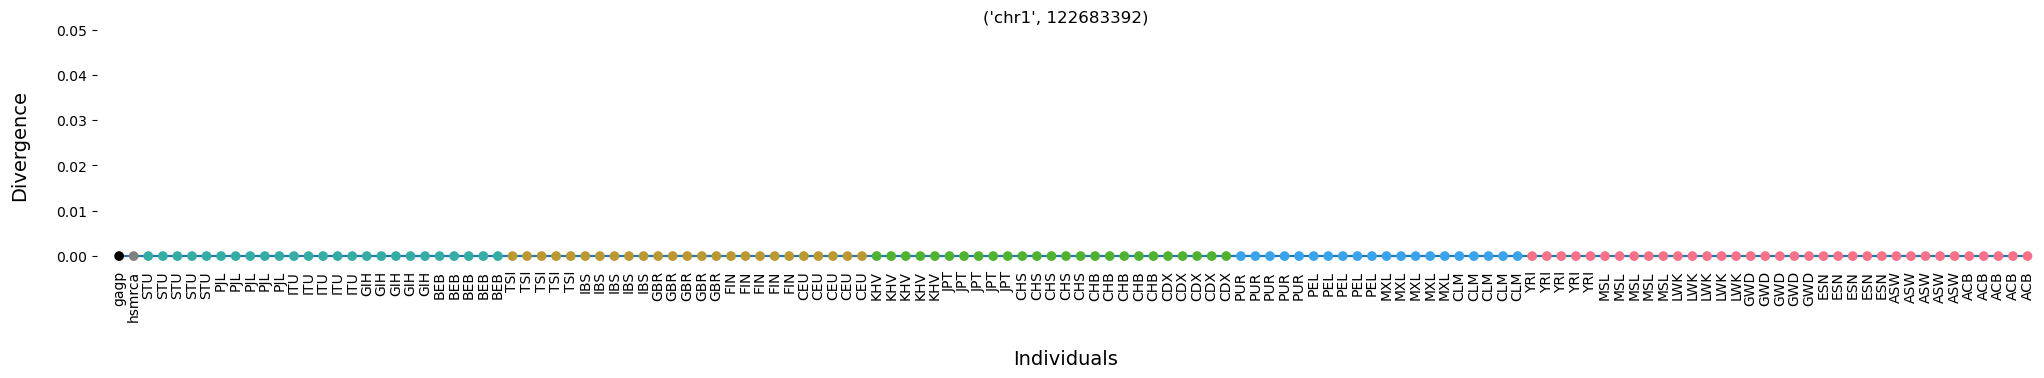

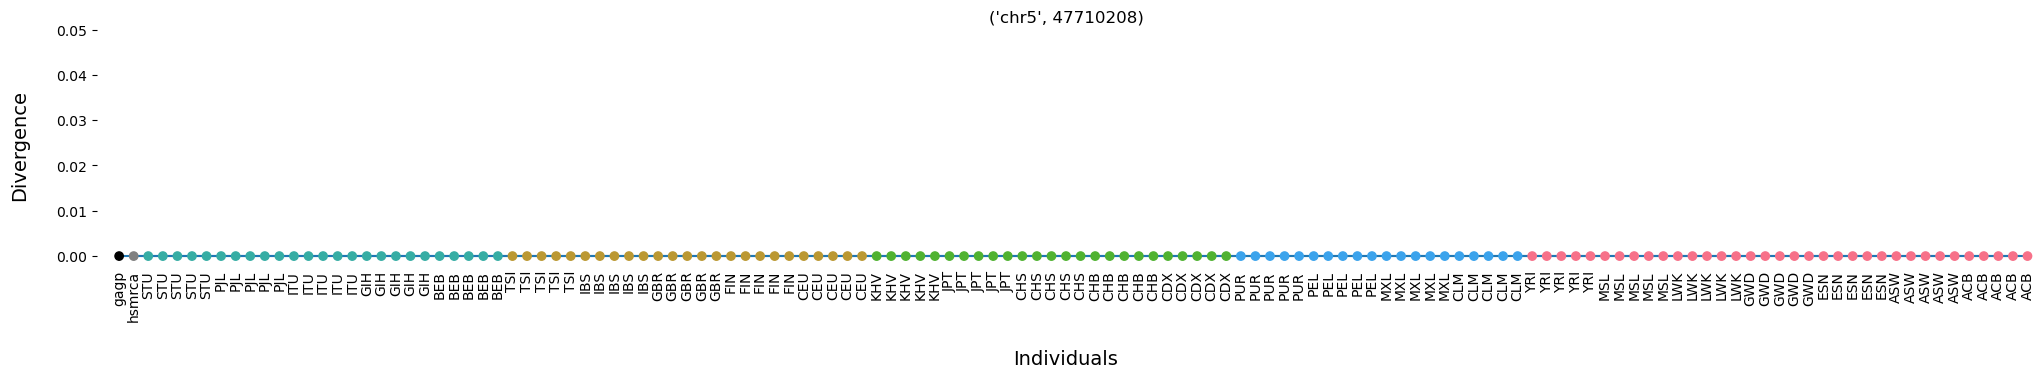

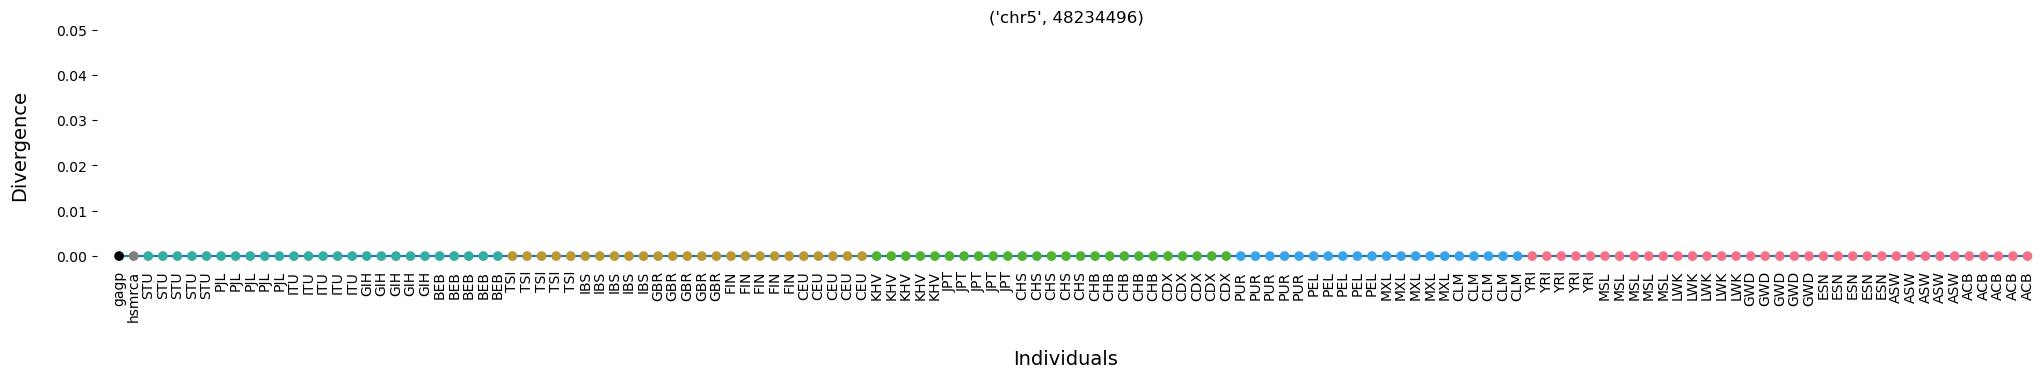

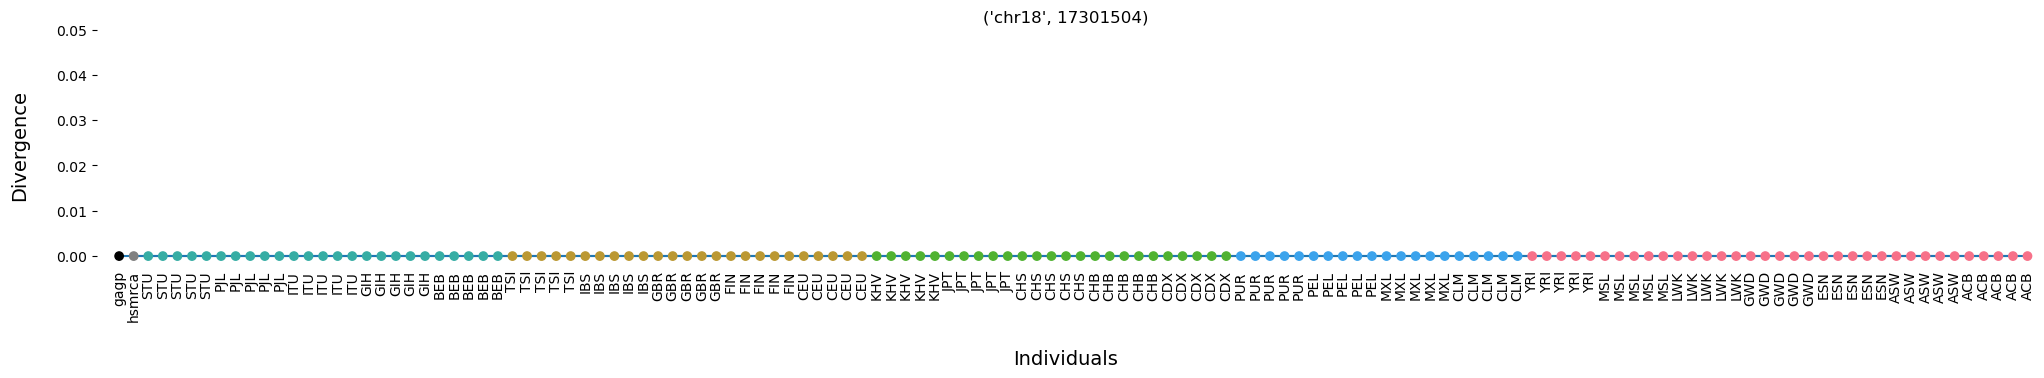

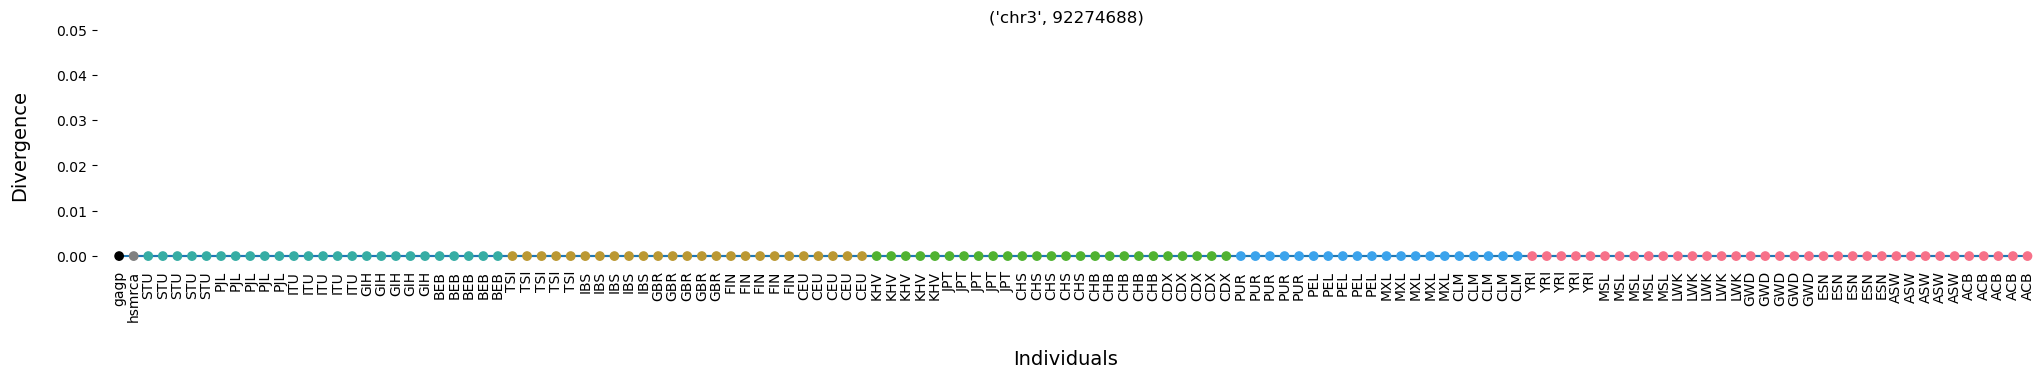

In [116]:
for w in tree_comp_stats.sort_values(by=['norm_rf']).head().index:
    get_window_dendrogram(w,idx)

### To Sequence collapsed tree

In [35]:
trees_phylo = {}
for w in windows_tuples:
    Z = tree_complete[w][0]
    T = PhyloTree(to_newick(hc.to_tree(Z), non_adm_ids))
    
    trees_phylo[w] = T

In [36]:
print(trees_phylo[w])


                                 /-EAS_KHV_female_HG02075
                              /-|
                           /-|   \-EAS_JPT_female_NA18998
                          |  |
                          |   \-SAS_ITU_female_HG03784
                        /-|
                       |  |      /-EUR_GBR_female_HG00255
                       |  |   /-|
                       |  |  |   \-AFR_GWD_female_HG02888
                       |   \-|
                       |     |      /-SAS_PJL_female_HG02655
                       |     |   /-|
                       |      \-|   \-EAS_JPT_female_NA18981
                       |        |
                       |         \-SAS_STU_female_HG03949
                     /-|
                    |  |            /-EUR_TSI_female_NA20505
                    |  |         /-|
                    |  |        |   \-EUR_FIN_female_HG00373
                    |  |      /-|
                    |  |     |  |      /-EUR_IBS_female_HG01710
                    |

In [40]:
# Load the species tree
species_tree = seq_base

# Define a function to map gene tree leaves to species
def map_leaf_to_species(gene_leaf_name):
    species = gene_leaf_name.split("_")[0]
    return species

# Load the gene trees
gene_trees = trees_phylo



In [38]:
stree_supports = {}
for name, gene_tree in gene_trees.items():
    # Map gene tree leaves to species
    gene_tree.set_species_naming_function(map_leaf_to_species)
    
    #Reconcile gene tree with species tree
    comp = species_tree.reconcile(gene_tree)
    rf_distance = comp['rf']
    print(rf_distance)
    weight = 1 / float(rf_distance + 1)
    stree_supports[name] = weight

# Normalize supports to sum to 1
total_support = sum(stree_supports.values())
for name in stree_supports:
    stree_supports[name] /= total_support

# Print supports
for name, support in stree_supports.items():
    print(name, support)

KeyError: '* The following species are not contained in the species tree: EUR,SAS'

In [42]:
recon_tree, events = gene_tree.reconcile(species_tree)

AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
EAS
EAS
EAS
EAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
EAS
EAS
SAS
SAS
SAS
EAS
EAS
SAS
SAS
SAS
AFR
AFR
AFR
AFR
SAS
SAS
SAS
EAS
EAS
AFR
AFR
SAS
SAS
SAS
EAS
EAS
AFR
AFR
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
SAS
EUR
EUR
EUR
EUR
SAS
SAS
SAS
EUR
EUR
SAS
SAS
SAS
EUR
EUR
SAS
SAS
SAS
EAS
EAS
AFR
AFR
SAS
SAS
SAS
EUR
EUR
SAS
SAS
SAS
EAS
EAS
AFR
AFR
SAS
SAS
SAS
EUR
EUR
AFR
AFR
AFR
AFR
SAS
SAS
SAS
EAS
EAS
AFR
AFR
SAS
SAS
SAS
EUR
EUR
AFR
AFR
SAS
SAS
SAS
EAS
EAS
AFR
AFR
SAS
SAS
SAS
EUR
EUR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
SAS
SAS
SAS
EAS
EAS
AFR
AFR
SAS
SAS
SAS
EUR
EUR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
AFR
SAS
SAS
SAS
EAS
EAS
AFR
AFR
SAS
SAS
SAS
EUR
EUR
AFR
AFR
SAS
AFR
SAS
AFR
EAS
EAS
EAS
EAS
SAS
AFR
EAS
EAS
SAS
AFR
EAS
EAS
AFR
AFR
AFR
AFR
SAS
AFR
EAS
EAS
AFR
AFR
SAS
AFR
EAS
EAS
AFR
AFR


In [44]:
print(recon_tree)


         /-hsmrca
        |
        |            /-SAS
        |         /-|
        |      /-|   \-EUR
        |     |  |
        |     |   \-EAS
        |     |
        |   /-|      /-AFR_GWD_female_HG02679
        |  |  |   /-|
        |  |  |  |   \-AFR_ESN_female_HG03159
        |  |  |  |
        |  |  |  |         /-AFR_YRI_female_NA19129
      /-|  |   \-|      /-|
     |  |  |     |     |   \-AFR_ESN_female_HG02974
     |  |  |     |   /-|
     |  |  |     |  |  |   /-AFR_YRI_female_NA19116
     |  |  |     |  |   \-|
     |  |  |      \-|      \-AFR_GWD_female_HG02814
     |  |  |        |
     |  |  |        |   /-AFR_YRI_female_NA19172
     |  |  |         \-|
     |  |  |            \-AFR_LWK_female_NA19446
     |  |  |
     |  |  |               /-EUR
     |  |  |              |
     |  |  |            /-|      /-SAS_PJL_female_HG02731
     |   \-|           |  |   /-|
     |     |           |   \-|   \-SAS_PJL_female_HG02649
     |     |         /-|     |
     |     |  

In [46]:
print("Orthology and Paralogy relationships:")
for ev in events:
    if ev.etype == "S":
        print('ORTHOLOGY RELATIONSHIP:', ','.join(ev.inparalogs), "<====>", ','.join(ev.orthologs))
    elif ev.etype == "D":
        print('PARALOGY RELATIONSHIP:', ','.join(ev.inparalogs), "<====>", ','.join(ev.outparalogs))


Orthology and Paralogy relationships:
PARALOGY RELATIONSHIP: AFR_GWD_female_HG02679 <====> AFR_ESN_female_HG03159
PARALOGY RELATIONSHIP: AFR_YRI_female_NA19129 <====> AFR_ESN_female_HG02974
PARALOGY RELATIONSHIP: AFR_YRI_female_NA19116 <====> AFR_GWD_female_HG02814
PARALOGY RELATIONSHIP: AFR_YRI_female_NA19129,AFR_ESN_female_HG02974 <====> AFR_YRI_female_NA19116,AFR_GWD_female_HG02814
PARALOGY RELATIONSHIP: AFR_YRI_female_NA19172 <====> AFR_LWK_female_NA19446
PARALOGY RELATIONSHIP: AFR_YRI_female_NA19129,AFR_ESN_female_HG02974,AFR_YRI_female_NA19116,AFR_GWD_female_HG02814 <====> AFR_YRI_female_NA19172,AFR_LWK_female_NA19446
PARALOGY RELATIONSHIP: AFR_GWD_female_HG02679,AFR_ESN_female_HG03159 <====> AFR_YRI_female_NA19129,AFR_ESN_female_HG02974,AFR_YRI_female_NA19116,AFR_GWD_female_HG02814,AFR_YRI_female_NA19172,AFR_LWK_female_NA19446
PARALOGY RELATIONSHIP: EAS_JPT_female_NA18998 <====> EAS_CHB_female_NA18591
PARALOGY RELATIONSHIP: SAS_PJL_female_HG02731 <====> SAS_PJL_female_HG02649
PA

In [75]:
def write_trees_to_file(trees, output_file):
    with open(output_file, "w") as f:
        for name, tree in trees.items():
            #f.write(">" + name + "\n") # Write tree name as a header
            f.write(tree.write(format=1).strip() + "\n") # Write tree in Newick format

# Example usage:

output_file = "trees.txt"
write_trees_to_file(trees, output_file)

In [52]:
len(trees.keys())

4873

In [55]:
with open('fake_base.txt', "w") as f:
    f.write(fake_base.write(format=1).strip())
    

In [54]:
with open('seq_base.txt', "w") as f:
    f.write(seq_base.write(format=1).strip())

In [57]:
non_adm_ids

['AFR_ESN_female_HG02946',
 'AFR_ESN_female_HG02974',
 'AFR_ESN_female_HG03111',
 'AFR_ESN_female_HG03159',
 'AFR_ESN_female_HG03511',
 'AFR_GWD_female_HG02635',
 'AFR_GWD_female_HG02679',
 'AFR_GWD_female_HG02814',
 'AFR_GWD_female_HG02879',
 'AFR_GWD_female_HG02888',
 'AFR_LWK_female_NA19024',
 'AFR_LWK_female_NA19037',
 'AFR_LWK_female_NA19314',
 'AFR_LWK_female_NA19446',
 'AFR_LWK_female_NA19457',
 'AFR_MSL_female_HG03086',
 'AFR_MSL_female_HG03378',
 'AFR_MSL_female_HG03458',
 'AFR_MSL_female_HG03575',
 'AFR_MSL_female_HG03583',
 'AFR_YRI_female_NA19116',
 'AFR_YRI_female_NA19129',
 'AFR_YRI_female_NA19137',
 'AFR_YRI_female_NA19172',
 'AFR_YRI_female_NA19206',
 'EAS_CDX_female_HG00864',
 'EAS_CDX_female_HG01799',
 'EAS_CDX_female_HG01801',
 'EAS_CDX_female_HG01807',
 'EAS_CDX_female_HG02188',
 'EAS_CHB_female_NA18531',
 'EAS_CHB_female_NA18541',
 'EAS_CHB_female_NA18591',
 'EAS_CHB_female_NA18596',
 'EAS_CHB_female_NA18631',
 'EAS_CHS_female_HG00531',
 'EAS_CHS_female_HG00566',
 

In [58]:
sup_idx_non_adm

['AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'AFR',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EAS',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'EUR',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'SAS',
 'hsmrca',
 'gagp']

In [64]:
ind_mapping = {key: [] for key in ['AFR','EUR','EAS','SAS','hsmrca','gagp']}

for i in non_adm_ids:
    print(i)
    p = i.split('_')[0]
    print(p)
    print(ind_mapping[p])
    ind_mapping[p] += [i]
    print(ind_mapping[p])


AFR_ESN_female_HG02946
AFR
[]
['AFR_ESN_female_HG02946']
AFR_ESN_female_HG02974
AFR
['AFR_ESN_female_HG02946']
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG02974']
AFR_ESN_female_HG03111
AFR
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG02974']
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG02974', 'AFR_ESN_female_HG03111']
AFR_ESN_female_HG03159
AFR
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG02974', 'AFR_ESN_female_HG03111']
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG02974', 'AFR_ESN_female_HG03111', 'AFR_ESN_female_HG03159']
AFR_ESN_female_HG03511
AFR
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG02974', 'AFR_ESN_female_HG03111', 'AFR_ESN_female_HG03159']
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG02974', 'AFR_ESN_female_HG03111', 'AFR_ESN_female_HG03159', 'AFR_ESN_female_HG03511']
AFR_GWD_female_HG02635
AFR
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG02974', 'AFR_ESN_female_HG03111', 'AFR_ESN_female_HG03159', 'AFR_ESN_female_HG03511']
['AFR_ESN_female_HG02946', 'AFR_ESN_female_HG

In [65]:
ind_mapping

{'AFR': ['AFR_ESN_female_HG02946',
  'AFR_ESN_female_HG02974',
  'AFR_ESN_female_HG03111',
  'AFR_ESN_female_HG03159',
  'AFR_ESN_female_HG03511',
  'AFR_GWD_female_HG02635',
  'AFR_GWD_female_HG02679',
  'AFR_GWD_female_HG02814',
  'AFR_GWD_female_HG02879',
  'AFR_GWD_female_HG02888',
  'AFR_LWK_female_NA19024',
  'AFR_LWK_female_NA19037',
  'AFR_LWK_female_NA19314',
  'AFR_LWK_female_NA19446',
  'AFR_LWK_female_NA19457',
  'AFR_MSL_female_HG03086',
  'AFR_MSL_female_HG03378',
  'AFR_MSL_female_HG03458',
  'AFR_MSL_female_HG03575',
  'AFR_MSL_female_HG03583',
  'AFR_YRI_female_NA19116',
  'AFR_YRI_female_NA19129',
  'AFR_YRI_female_NA19137',
  'AFR_YRI_female_NA19172',
  'AFR_YRI_female_NA19206'],
 'EUR': ['EUR_CEU_female_NA06985',
  'EUR_CEU_female_NA07000',
  'EUR_CEU_female_NA12044',
  'EUR_CEU_female_NA12046',
  'EUR_CEU_female_NA12778',
  'EUR_FIN_female_HG00326',
  'EUR_FIN_female_HG00330',
  'EUR_FIN_female_HG00331',
  'EUR_FIN_female_HG00334',
  'EUR_FIN_female_HG00373',
  'EU

In [70]:
def write_mapping_to_file(ind_mapping, output_file):
    with open(output_file, "w") as f:
        for pop, inds in ind_mapping.items():
            f.write(pop + ":") # Write pop name as a header
            f.write(','.join(inds) + "\n") 
# Example usage:

output_file = "mapping.txt"
write_mapping_to_file(ind_mapping, output_file)